# 1. Data Cleaning:

## Overview :

We cleaned the data as much as possible without introducing bias. Following is the shape of both raw and cleaned dataset:

- Raw dataset: 23980 x 67 

- Cleaned dataset: 23320 x 66

## Imports and basic informations about raw data

In [109]:
import pandas as pd
import numpy as np
import re

In [110]:
df_raw=pd.read_csv('../data/raw/raw_dataset_v4.csv')
df_raw.head()

,url,property_id,price,rooms,area,state,facades_number,is_furnished,has_terrace,has_garden,...,number_floors,toilets,diningrooms,frontage_width,terrain_width_roadside,g_score,p_score,cadastral_income,vat,maintenance_cost
0,https://immovlan.be/en/detail/apartment/for-sa...,rbu69315,269000.0,1.0,51.0,NaN,NaN,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,: No,NaN
1,https://immovlan.be/en/detail/apartment/for-sa...,rbu69316,299000.0,2.0,79.0,Normal,2.0,0.0,1.0,0.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,: No,NaN
2,https://immovlan.be/en/detail/apartment/for-sa...,rbu68996,359000.0,3.0,110.0,NaN,NaN,0.0,1.0,0.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,: No,NaN
3,https://immovlan.be/en/detail/apartment/for-sa...,rbu69309,239000.0,2.0,84.0,Normal,2.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,: No,NaN
4,https://immovlan.be/en/detail/apartment/for-sa...,rbu69307,189000.0,2.0,80.0,Normal,2.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,: No,NaN


In [111]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23981 entries, 0 to 23980
Data columns (total 67 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   url                                    23981 non-null  object 
 1   property_id                            23981 non-null  object 
 2   price                                  22306 non-null  float64
 3   rooms                                  22677 non-null  float64
 4   area                                   21853 non-null  float64
 5   state                                  18088 non-null  object 
 6   facades_number                         16658 non-null  float64
 7   is_furnished                           13249 non-null  float64
 8   has_terrace                            21834 non-null  float64
 9   has_garden                             20824 non-null  float64
 10  has_swimming_pool                      6943 non-null   object 
 11  ha

## Utils functions

In [112]:

# ---------------------------------------------------------
# 1. RAW URL EXTRACTION (property_subtype, postal_code, locality)
# ---------------------------------------------------------

def extract_from_url(df, url_col="url"):
    df = df.copy()

    # property subtype (residence, villa, mixed-building, duplex, etc.)
    df['property_subtype'] = df[url_col].str.extract(r'detail/([^/]+)/')[0]

    # postal code (4 digits)
    df['postal_code'] = df[url_col].str.extract(r'/(\d{4})/')[0]

    # locality (string after postal code)
    df['locality'] = df[url_col].str.extract(r'/(\d{4})/([^/]+)/')[1]

    return df


# ---------------------------------------------------------
# 2. CANONICAL IMMOVLAN SUBTYPE SETS
# ---------------------------------------------------------

HOUSE_SUBTYPES = {
    "residence",
    "villa",
    "mixed building",
    "master house",
    "cottage",
    "bungalow",
    "chalet",
    "mansion",
}

APARTMENT_SUBTYPES = {
    "apartment",
    "ground floor",
    "penthouse",
    "duplex",
    "studio",
    "loft",
    "triplex",
    "student flat",
    "student housing",
}


# ---------------------------------------------------------
# 3. CLEAN SUBTYPE (normalize dashes & spacing)
# ---------------------------------------------------------

def normalize_subtype(s):
    if not isinstance(s, str):
        return None
    s = s.lower().strip()
    s = s.replace("-", " ")
    s = re.sub(r'\s+', ' ', s)
    return s


# ---------------------------------------------------------
# 4. MAP TO MAIN PROPERTY TYPE (House / Apartment)
# ---------------------------------------------------------

def map_property_type(subtype):
    if not isinstance(subtype, str):
        return "Other"

    s = normalize_subtype(subtype)

    if s in HOUSE_SUBTYPES:
        return "House"
    if s in APARTMENT_SUBTYPES:
        return "Apartment"

    return "Other"


# ---------------------------------------------------------
# 5. FULL PIPELINED TRANSFORMATION
# ---------------------------------------------------------

def process_property_urls(df, url_col="url"):
    df = extract_from_url(df, url_col=url_col)

    # normalize subtype for consistent mapping
    df['property_subtype'] = df['property_subtype'].apply(normalize_subtype)

    # final property type
    df['property_type'] = df['property_subtype'].apply(map_property_type)

    return df

def normalize_yes_no(val):
    if not isinstance(val, str):
        return np.nan
    v = val.strip().lower()
    if v == "yes":
        return 1
    elif v == "no":
        return 0
    return np.nan

## Cleaning

In [113]:
# Drop specified columns from with all null values
#cols_to_drop = ['parking_places_outdoor', 'parking_places_indoor', 'wash_room','front_facade_orientation', 'diningrooms']
#df_raw.drop(columns=[c for c in cols_to_drop if c in df_raw.columns], inplace=True)

# Drop duplicates
df_raw = df_raw.drop_duplicates()

# Process property URLs to extract locality, postal_code, property_subtype
df_raw = process_property_urls(df_raw)

# Drop rows with missing locality, postal_code, or property_subtype (url linking to municipality page mainly due to projects landing pages)
df_raw = df_raw.dropna(subset=["locality", "postal_code", "property_subtype"], how="any")

#Price on request (NaN) for price encoded as -1
df_raw['price'] = df_raw['price'].fillna(-1)

#Change vat values (: No) to No and nan to NaN
df_raw['vat'] = (
    df_raw['vat']
    .astype(str)
    .str.strip()
    .str.replace(r'^:?\s*No$', 'No', regex=True)
)
df_raw['vat'] = df_raw['vat'].replace(['nan'], np.nan)

# Clean frontage_width and terrain_width_roadside columns
cols_to_clean = ["frontage_width", "terrain_width_roadside"]

df_raw[cols_to_clean] = (
    df_raw[cols_to_clean]
    .apply(lambda col: (
        col.astype(str)
           .str.replace("m", "", regex=False)
           .str.strip()
           .replace(["", "nan", "None"], np.nan)
           .astype(float)
    ))
)


#Yes/No columns mapping to 0,1 
yes_no_cols = ["leased", "running_water", "access_disabled", "preemption_right","has_swimming_pool",\
               "sewer_connection","attic", "cellar", "entry_phone","solar_panels","planning_permission_granted", \
                "alarm","heat_pump", "surroundings_protected", "air_conditioning","rain_water_tank",\
                "security_door","low_energy", "water_softener" , "opportunity_for_professional"]  #list of columns to convert

df_raw[yes_no_cols] = df_raw[yes_no_cols].apply(lambda col: col.map(normalize_yes_no))




## Saving clean dataset

In [114]:
df_raw.to_csv('../data/cleaned/cleaned_dataset_v4.csv', index=False)

# 2. Data analysis

## Imports and basic informations about cleaned data

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [116]:
df_clean=pd.read_csv('../data/cleaned/cleaned_dataset_v4.csv')
df_clean.head()

,url,property_id,price,rooms,area,state,facades_number,is_furnished,has_terrace,has_garden,...,terrain_width_roadside,g_score,p_score,cadastral_income,vat,maintenance_cost,property_subtype,postal_code,locality,property_type
0,https://immovlan.be/en/detail/apartment/for-sa...,rbu69315,269000.0,1.0,51.0,NaN,NaN,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,No,NaN,apartment,2600,berchem,Apartment
1,https://immovlan.be/en/detail/apartment/for-sa...,rbu69316,299000.0,2.0,79.0,Normal,2.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,No,NaN,apartment,2050,antwerp,Apartment
2,https://immovlan.be/en/detail/apartment/for-sa...,rbu68996,359000.0,3.0,110.0,NaN,NaN,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,No,NaN,apartment,2610,wilrijk,Apartment
3,https://immovlan.be/en/detail/apartment/for-sa...,rbu69309,239000.0,2.0,84.0,Normal,2.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,No,NaN,apartment,2060,antwerp,Apartment
4,https://immovlan.be/en/detail/apartment/for-sa...,rbu69307,189000.0,2.0,80.0,Normal,2.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,No,NaN,apartment,2610,wilrijk,Apartment


In [117]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23320 entries, 0 to 23319
Data columns (total 71 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   url                                    23320 non-null  object 
 1   property_id                            23320 non-null  object 
 2   price                                  23320 non-null  float64
 3   rooms                                  22677 non-null  float64
 4   area                                   21853 non-null  float64
 5   state                                  18088 non-null  object 
 6   facades_number                         16658 non-null  float64
 7   is_furnished                           13249 non-null  float64
 8   has_terrace                            21834 non-null  float64
 9   has_garden                             20824 non-null  float64
 10  has_swimming_pool                      6943 non-null   float64
 11  ha

In [118]:
df_clean.describe(include='all')

,url,property_id,price,rooms,area,state,facades_number,is_furnished,has_terrace,has_garden,...,terrain_width_roadside,g_score,p_score,cadastral_income,vat,maintenance_cost,property_subtype,postal_code,locality,property_type
count,23320,23320,2.332000e+04,22677.000000,21853.000000,18088,16658.000000,13249.000000,21834.000000,20824.000000,...,2954.00000,1576,1512,7539.000000,16800,556.000000,23320,23320.000000,23320,23320
unique,23320,23320,NaN,NaN,NaN,9,NaN,NaN,NaN,NaN,...,NaN,2,2,NaN,1,NaN,24,NaN,1313,3
top,https://immovlan.be/en/detail/villa/for-sale/1...,vbc94355,NaN,NaN,NaN,New,NaN,NaN,NaN,NaN,...,NaN,A,A,NaN,No,NaN,apartment,NaN,liege,Apartment
freq,1,1,NaN,NaN,NaN,7822,NaN,NaN,NaN,NaN,...,NaN,1416,1249,NaN,16800,NaN,10041,NaN,854,11946
mean,NaN,NaN,3.467045e+05,2.728844,165.632636,NaN,2.758434,0.028681,0.819044,0.584902,...,16.82566,NaN,NaN,1160.721183,NaN,350.834532,NaN,5228.727230,NaN,NaN
std,NaN,NaN,3.868123e+05,1.860211,2851.550206,NaN,0.825319,0.166916,0.384991,0.492751,...,79.27000,NaN,NaN,10021.253152,NaN,3199.000215,NaN,2705.214215,NaN,NaN
min,NaN,NaN,-1.000000e+00,0.000000,1.000000,NaN,1.000000,0.000000,0.000000,0.000000,...,2.00000,NaN,NaN,1.000000,NaN,1.000000,NaN,1000.000000,NaN,NaN
25%,NaN,NaN,2.100000e+05,2.000000,88.000000,NaN,2.000000,0.000000,1.000000,0.000000,...,6.00000,NaN,NaN,508.500000,NaN,100.000000,NaN,2610.000000,NaN,NaN
50%,NaN,NaN,2.990000e+05,3.000000,119.000000,NaN,3.000000,0.000000,1.000000,1.000000,...,9.00000,NaN,NaN,800.000000,NaN,162.500000,NaN,5030.000000,NaN,NaN
75%,NaN,NaN,4.050000e+05,3.000000,170.000000,NaN,3.000000,0.000000,1.000000,1.000000,...,14.00000,NaN,NaN,1172.000000,NaN,250.000000,NaN,7522.000000,NaN,NaN


## Features:

We will provide an overview of dataset columns by category with possible actions to perform on these columns

### i. Block A — Identifiers / Technical Columns:

**Purpose:** Metadata only → not useful for statistics, correlations, or clustering.

**Columns:**

- url

- property_id

**Actions:**

- Kept only for traceability (to open the listing again).

- Excluded from correlation, modeling, clustering, visualization.

- We will not impute or transform.

- Can optionally be dropped from analysis

### ii. Block B — Core Structural, Location & Pricing Features:

**Purpose:** Essential for EDA, correlations, and price modeling.

**Columns:**

*Location*:
- postal_code

- locality

- Optionally region derived from postal_code


*Property Structure:*

- property_type (House/Apartment)

- property_subtype

- facades_number

- rooms

- bathrooms

- has_terrace

- has_garden

- toilets

- apartement_floor (apartment-only)

- elevator (apartment-only)

*Size Metrics:*

- area


*Pricing:*

- price

- price_per_m2 (computed)

*Age / Condition:*

- build_year

- state (renovated / new / to renovate / etc.)

*Actions:*

- Try to keep all → these are the backbone of analysis.

- Handle missing values manually where needed.

- Detect and handle outliers.

*Used for:*

- correlation with price

- clustering into luxury tiers

- municipality ranking

- regression / predictive analysis

- For extremely skewed variables: we will apply log-transform.


### iii. Block C — Amenities, Utilities, Comfort, Energy, and Legal Features:

**Purpose**: Useful but more missing, type-specific, or more difficult to interpret.

**Columns:**

*Amenities:*

- garage

- cellar

- attic

- parking

- entry_phone

- has_equipped_kitchen

- has_swimming_pool

- running_water

- sewer_connection

- access_disabled

*Energy / Heating / Glazing:*

- heating_type

- glazing_type

- epc_value

- co2

- solar_panels

- heat_pump


*Legal:*

- planning_permission_granted

- preemption_right

- cadastral_income

- vat

- leased

- availability (text/date mix)

*Surroundings:*

- surroundings_protected

- flooding_area_type

- demarcated_flooding_area

**Actions:**

- Kept for EDA and interpretation when relevant.

- Used carefully in modeling

- High missingness → NaN treated as informative category

- Many are type-specific → kept only for type-segmented analysis

- For categorical columns → one-hot encoding or grouped categories used .


### iv. Block D — Ultra-Sparse / Niche Features (>90% missing):

**Purpose**: Too sparse for global analysis; may be relevant only for special cases.

**Columns:**

- certification_gasoil_tank

- opportunity_for_professional

- water_softener

- garden_orientation

- terrace_orientation

- low_energy

- maintenance_cost

- security_door

- rain_water_tank

- g_score

- p_score

- air_conditioning

- parking_places_outdoor

- parking_places_indoor

- wash_room

- front_facade_orientation

- diningrooms

**Actions:**

- Drop from general EDA, correlation, clustering, and modeling.

- Columns are too sparse and type-specific to provide reliable insights

- We may keep separately for niche-side analysis (e.g., new builds or specific municipalities).


## How many observations and features/columns do you have?

- 23320 observations

- 71 features

In [119]:
df_clean.shape

(23320, 71)

## What is the proportion of missing values per column?

In [120]:
pct_missing_df = (
    df_clean.isna().mean().sort_values(ascending=False) * 100
).round(2).rename_axis("column").reset_index(name="percent_missing")

pct_missing_df

,column,percent_missing
0,parking_places_indoor,100.0
1,diningrooms,100.0
2,front_facade_orientation,100.0
3,wash_room,100.0
4,parking_places_outdoor,100.0
...,...,...
66,url,0.0
67,property_subtype,0.0
68,postal_code,0.0
69,locality,0.0


In [121]:
total_entries = len(df_clean)
total_columns = len(df_clean.columns)

filled=df_clean.count()
filled=filled/total_entries
filled=filled*100
filled=filled.sort_values(ascending=False)
import plotly.express as px
fig = px.bar(filled)
fig.add_hline(y=50, line_dash="dash", line_color="red")
fig.add_hline(y=70, line_dash="dash", line_color="orange")
fig.add_hline(y=90, line_dash="dash", line_color="green")
fig.update_layout(xaxis_tickangle=-45, yaxis_title="Filled proportion (%)")
fig.show()

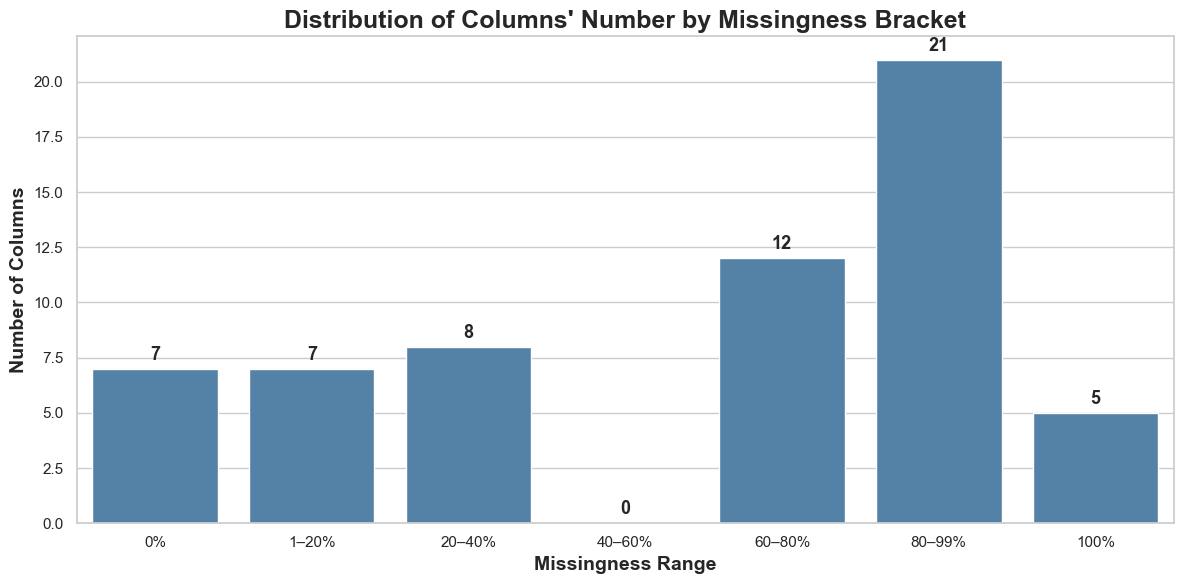

In [122]:
missing = pct_missing_df["percent_missing"]

# 1. Define brackets explicitly with boolean masks
ranges = {
    "0%":      (missing == 0),
    "1–20%":   (missing > 0) & (missing <= 20),
    "20–40%":  (missing > 20) & (missing <= 40),
    "40–60%":  (missing > 60) & (missing <= 60),
    "60–80%":  (missing > 60) & (missing <= 80),
    "80–99%":  (missing > 80) & (missing < 100),
    "100%":    (missing == 100),
}

# 2. Build summary table
bin_counts = pd.DataFrame({
    "missing_range": list(ranges.keys()),
    "n_columns": [mask.sum() for mask in ranges.values()]
})

# 3. Plot (simple, no seaborn palette warnings)
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

sns.barplot(
    data=bin_counts,
    x="missing_range",
    y="n_columns",
    color="steelblue"
)

plt.title("Distribution of Columns' Number by Missingness Bracket",
          fontsize=18, fontweight="bold")
plt.xlabel("Missingness Range", fontsize=14, fontweight="bold")
plt.ylabel("Number of Columns", fontsize=14, fontweight="bold")

# Add labels above bars
for i, v in enumerate(bin_counts["n_columns"]):
    plt.text(i, v + 0.4, str(v), ha="center", fontsize=13, fontweight="bold")

plt.tight_layout()
plt.show()


## Which variables would you delete and why?

Based on results from the previous section, we will drop the following columns first:

| Column | Reason |
| -------- | ------- |
| url  | Metadata only    |
| property_id | Metadata only     |
| parking_places_indoor | 100% Missing values    |
| diningrooms | 100% Missing values    |
| front_facade_orientation | 100% Missing values    |
| wash_room | 100% Missing values    |
| parking_places_outdoor | 100% Missing values    |
| parking_places_indoor | 100% Missing values    |

then we will perform missingness analysis


## Missingness Origin:

We need to determine whether high-missingness variables are:

- MCAR → Missing Completely At Random

- MNAR / Niche-specific → Missing Not At Random (depends on property type, subtype…)

In our case, we will check missingness against Property Type (House vs Apartment vs Other) for quick analysis and also because it  is the main factor from dataset

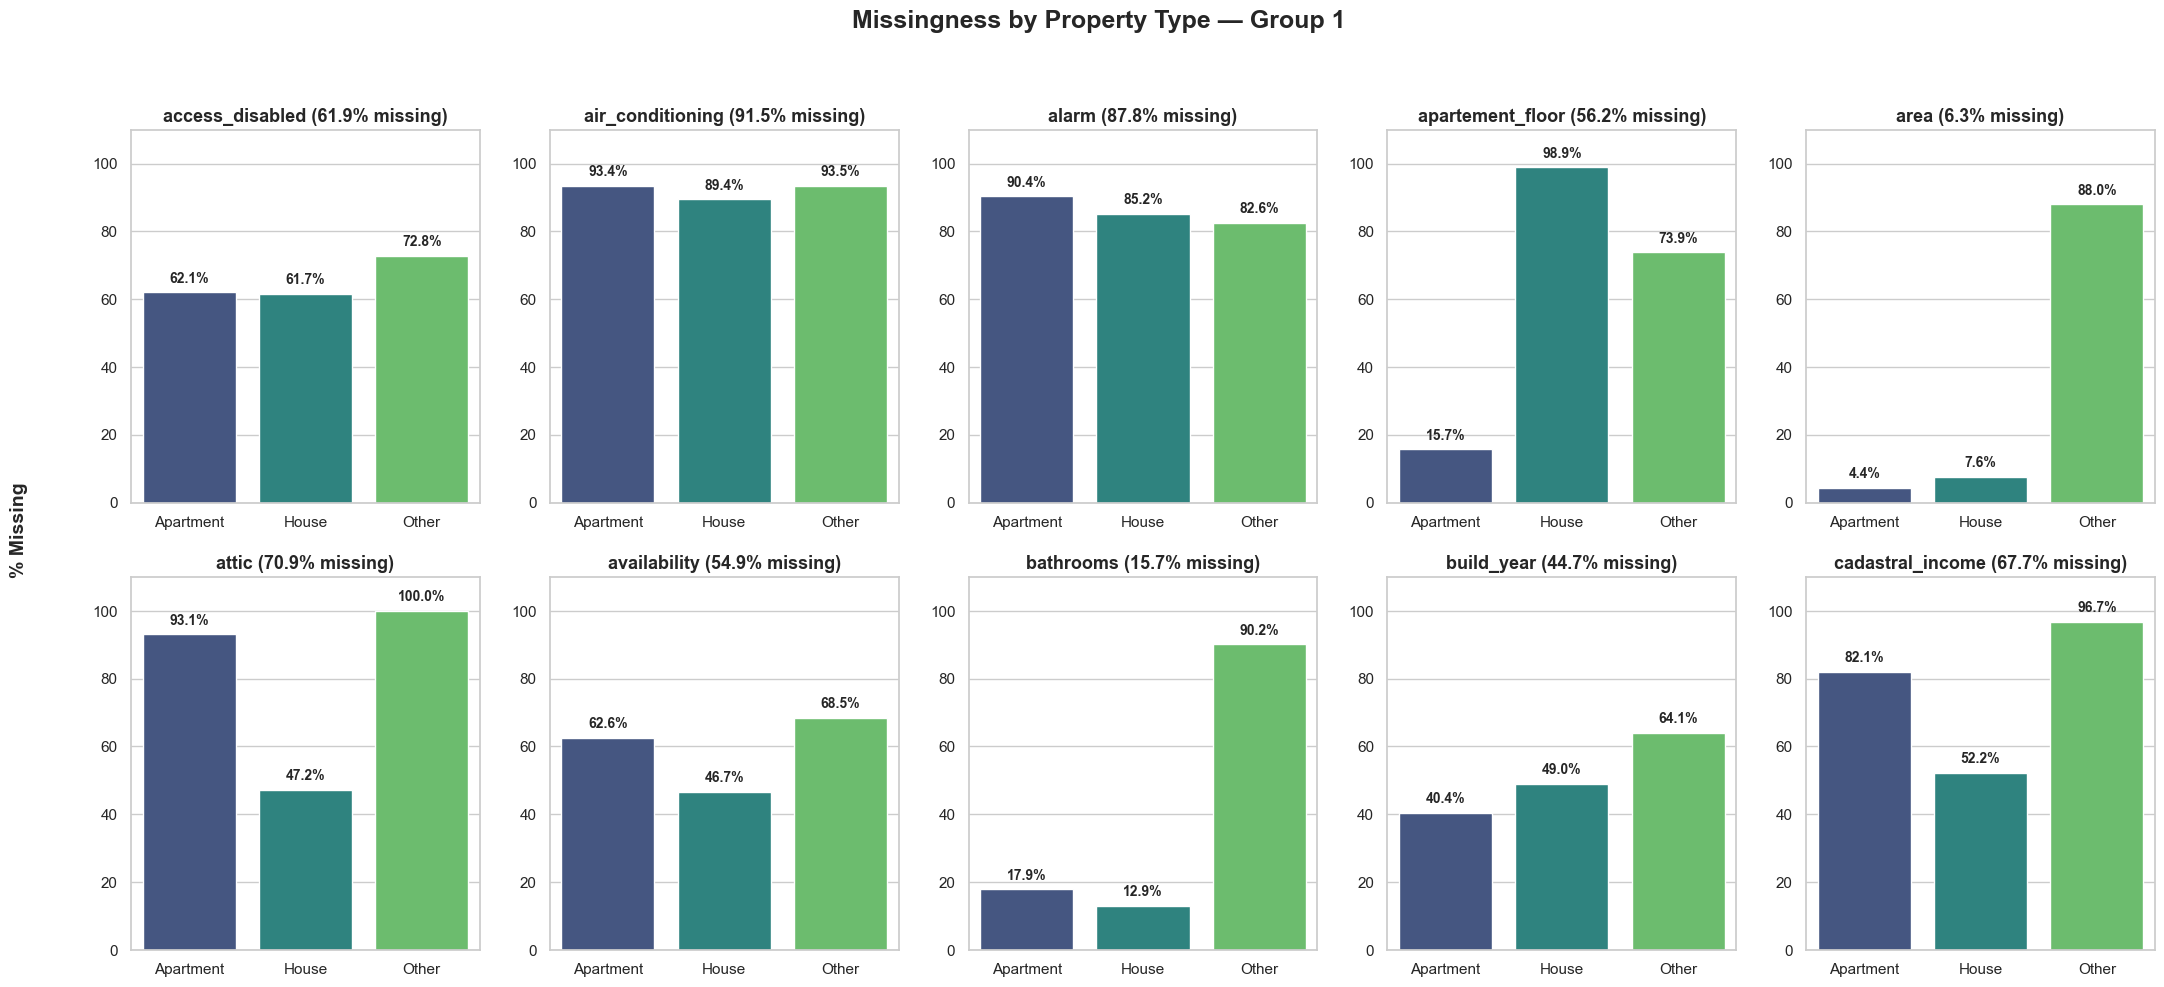

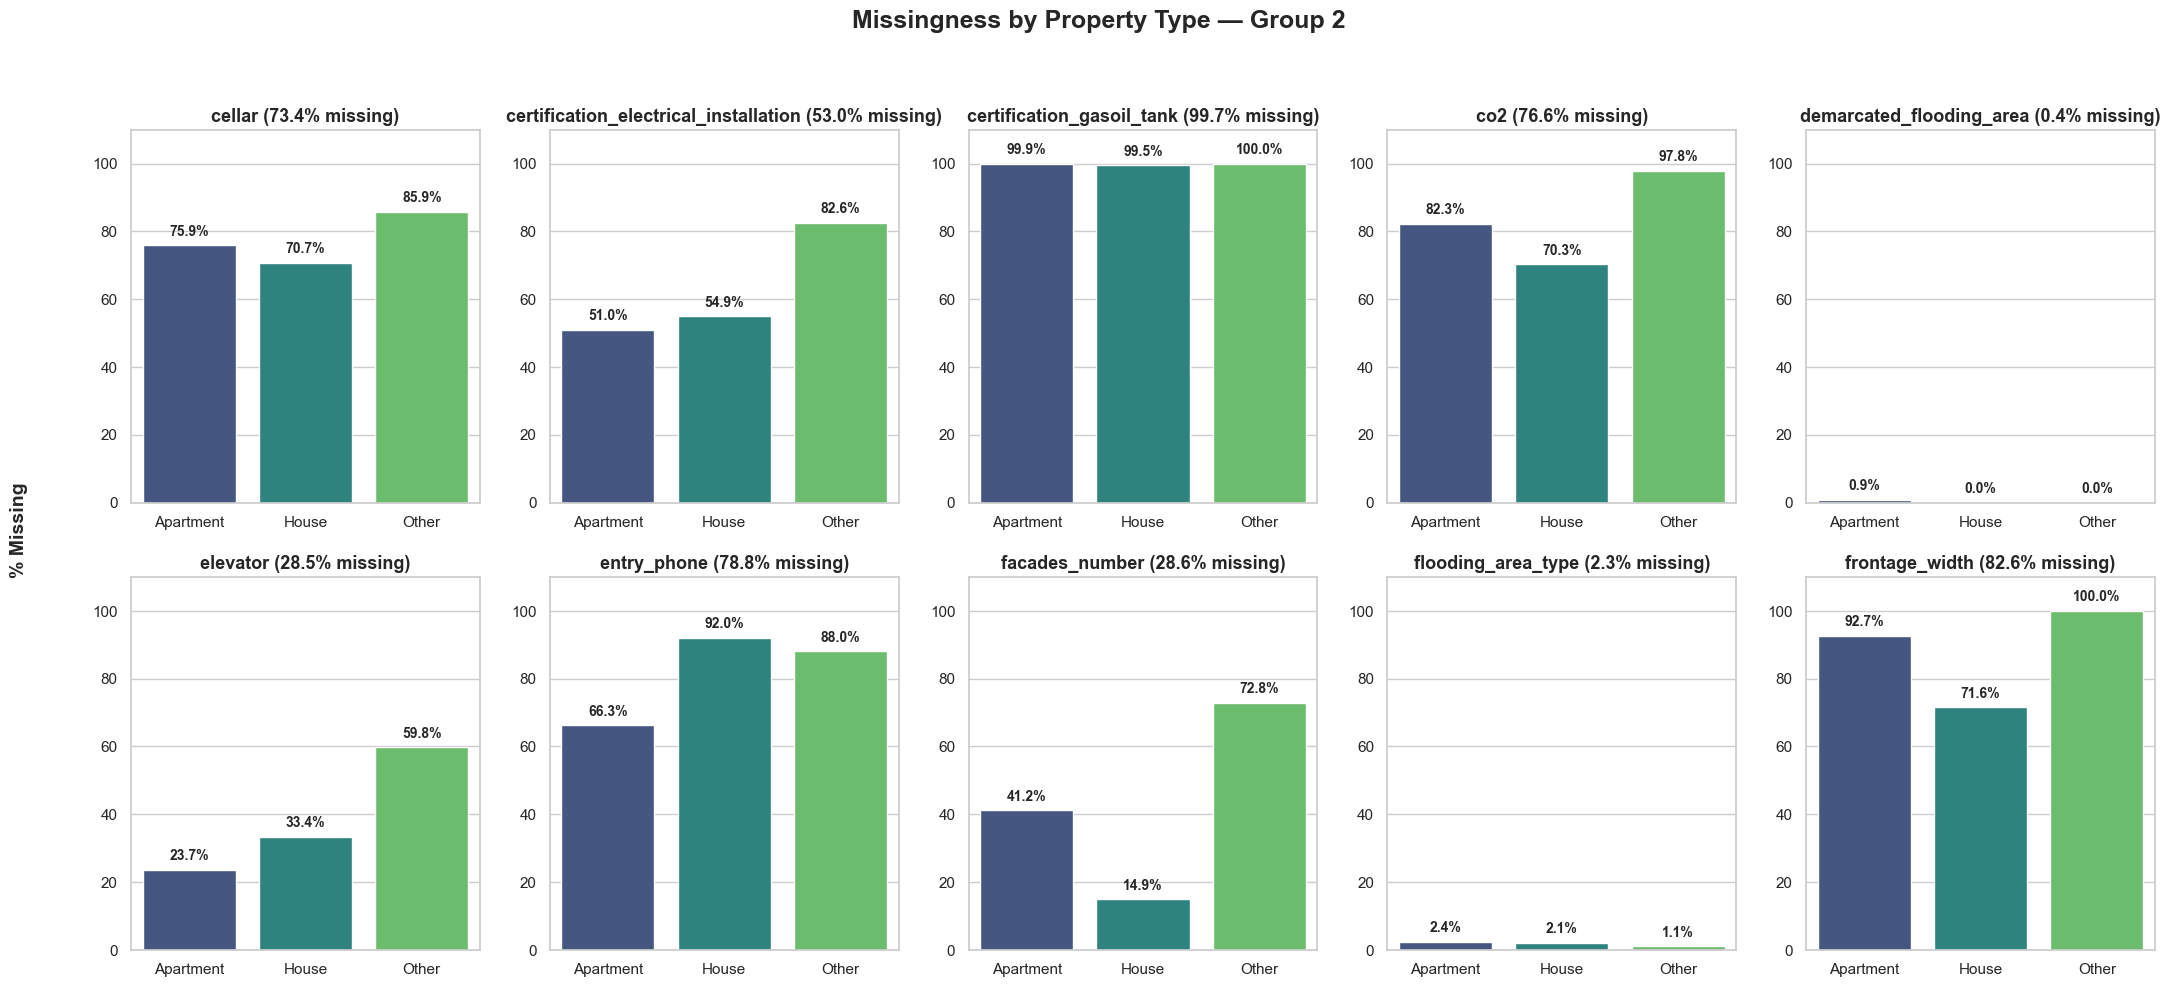

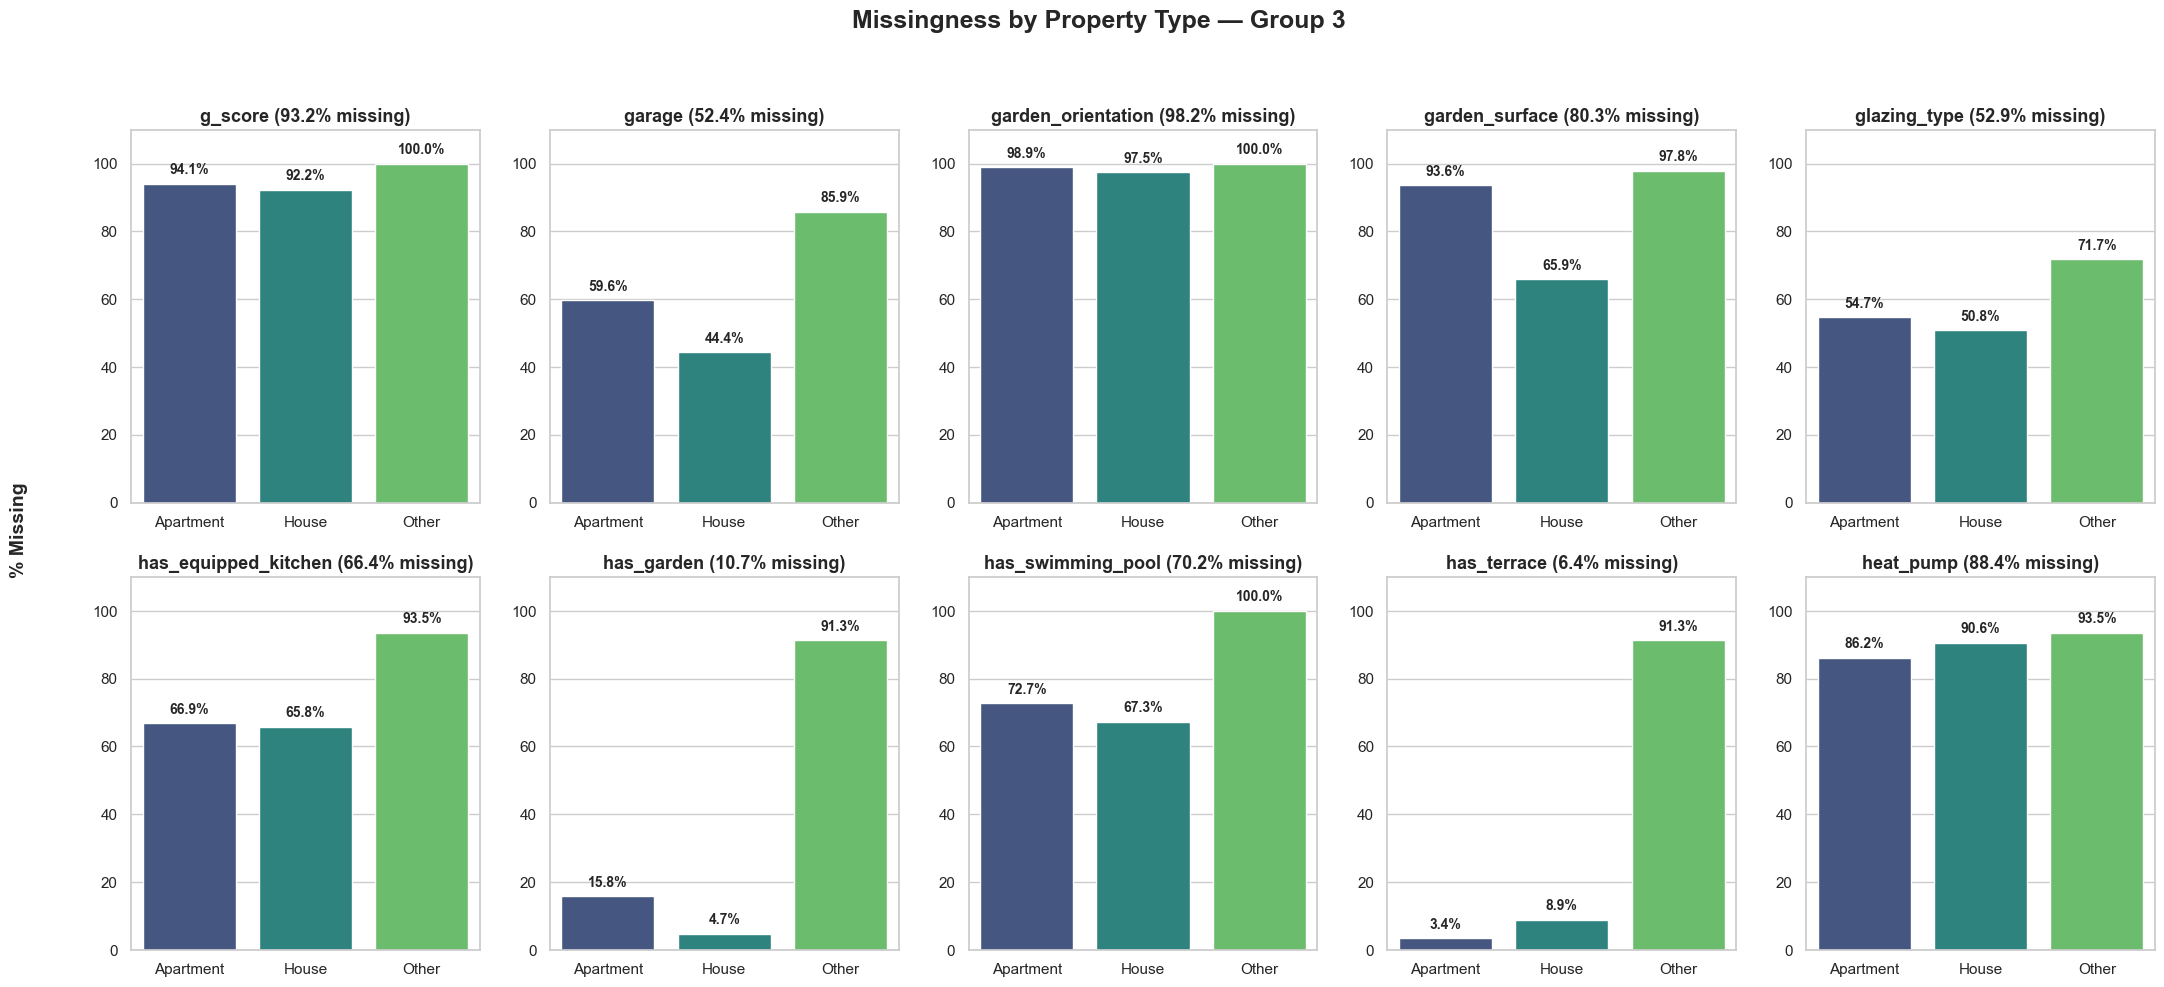

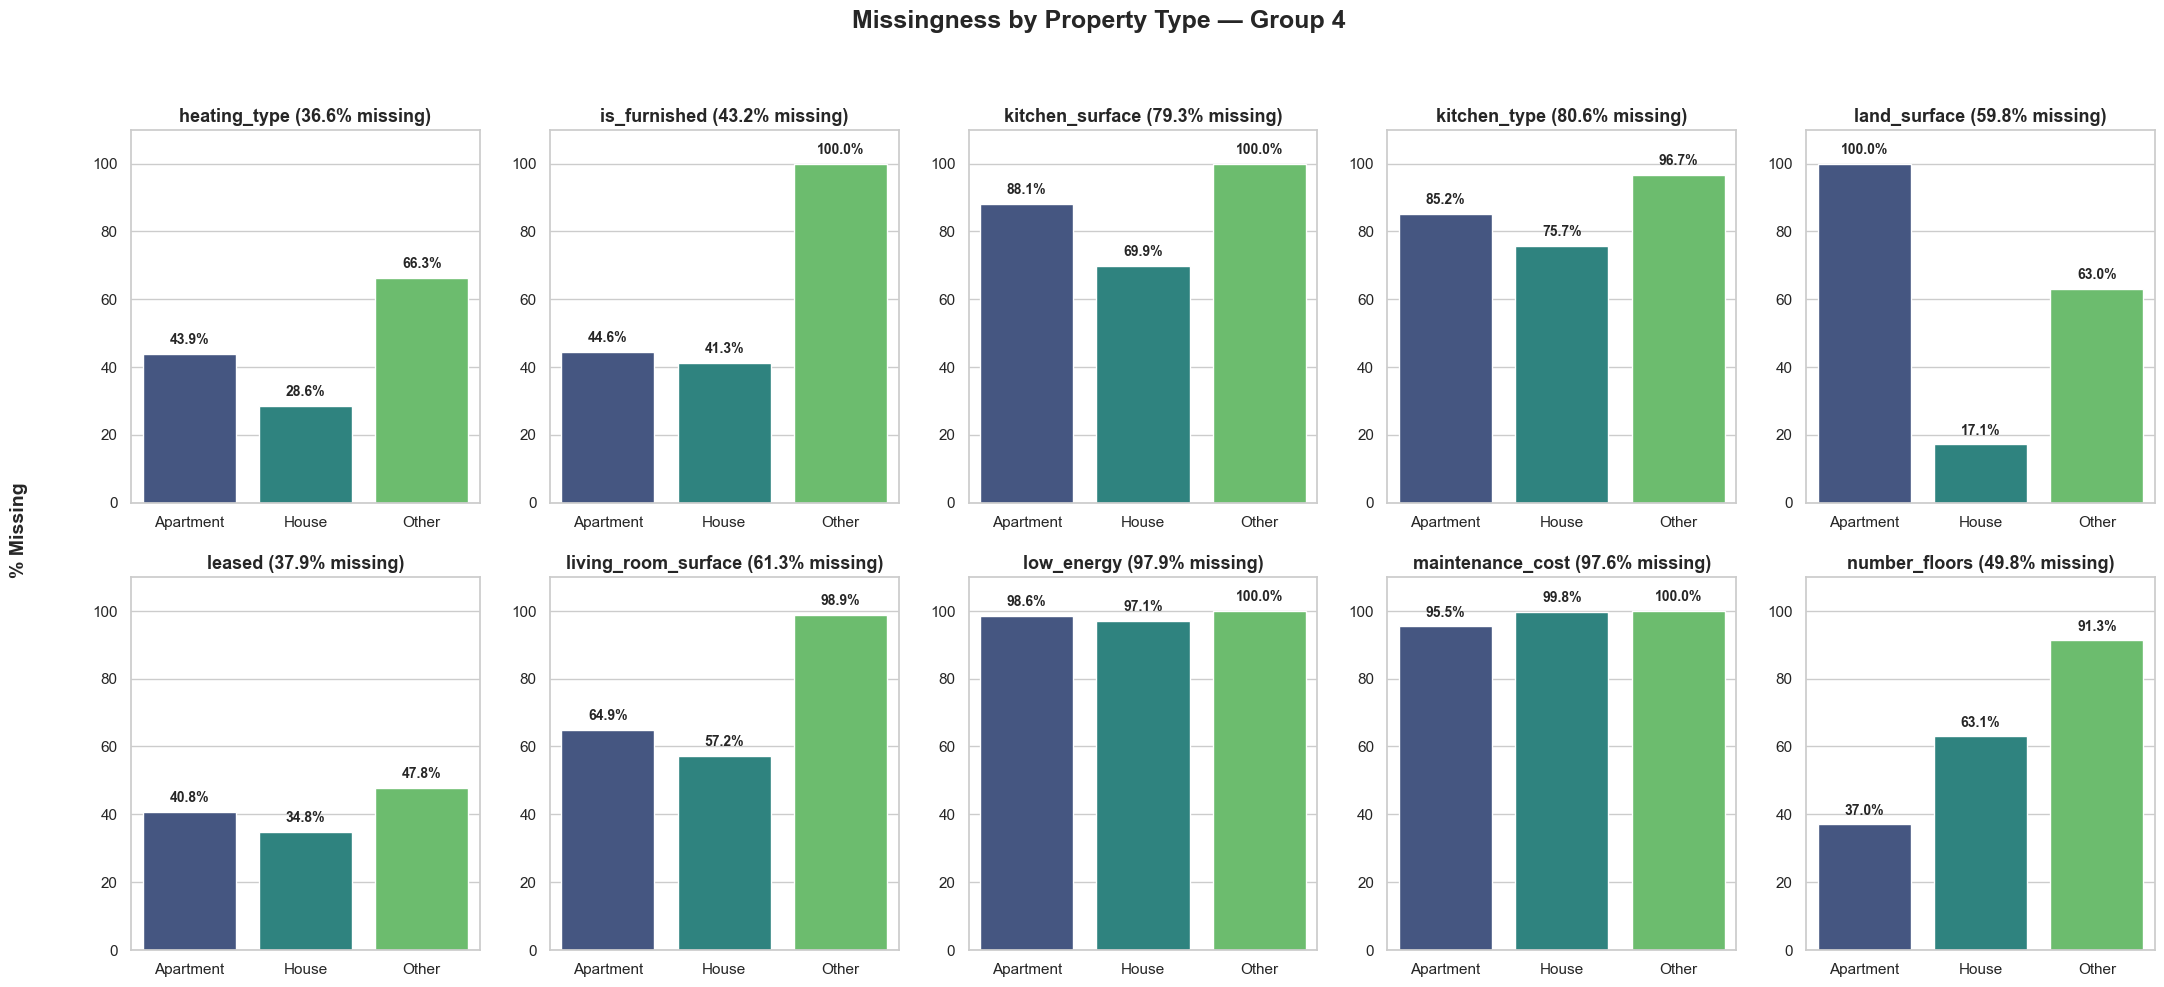

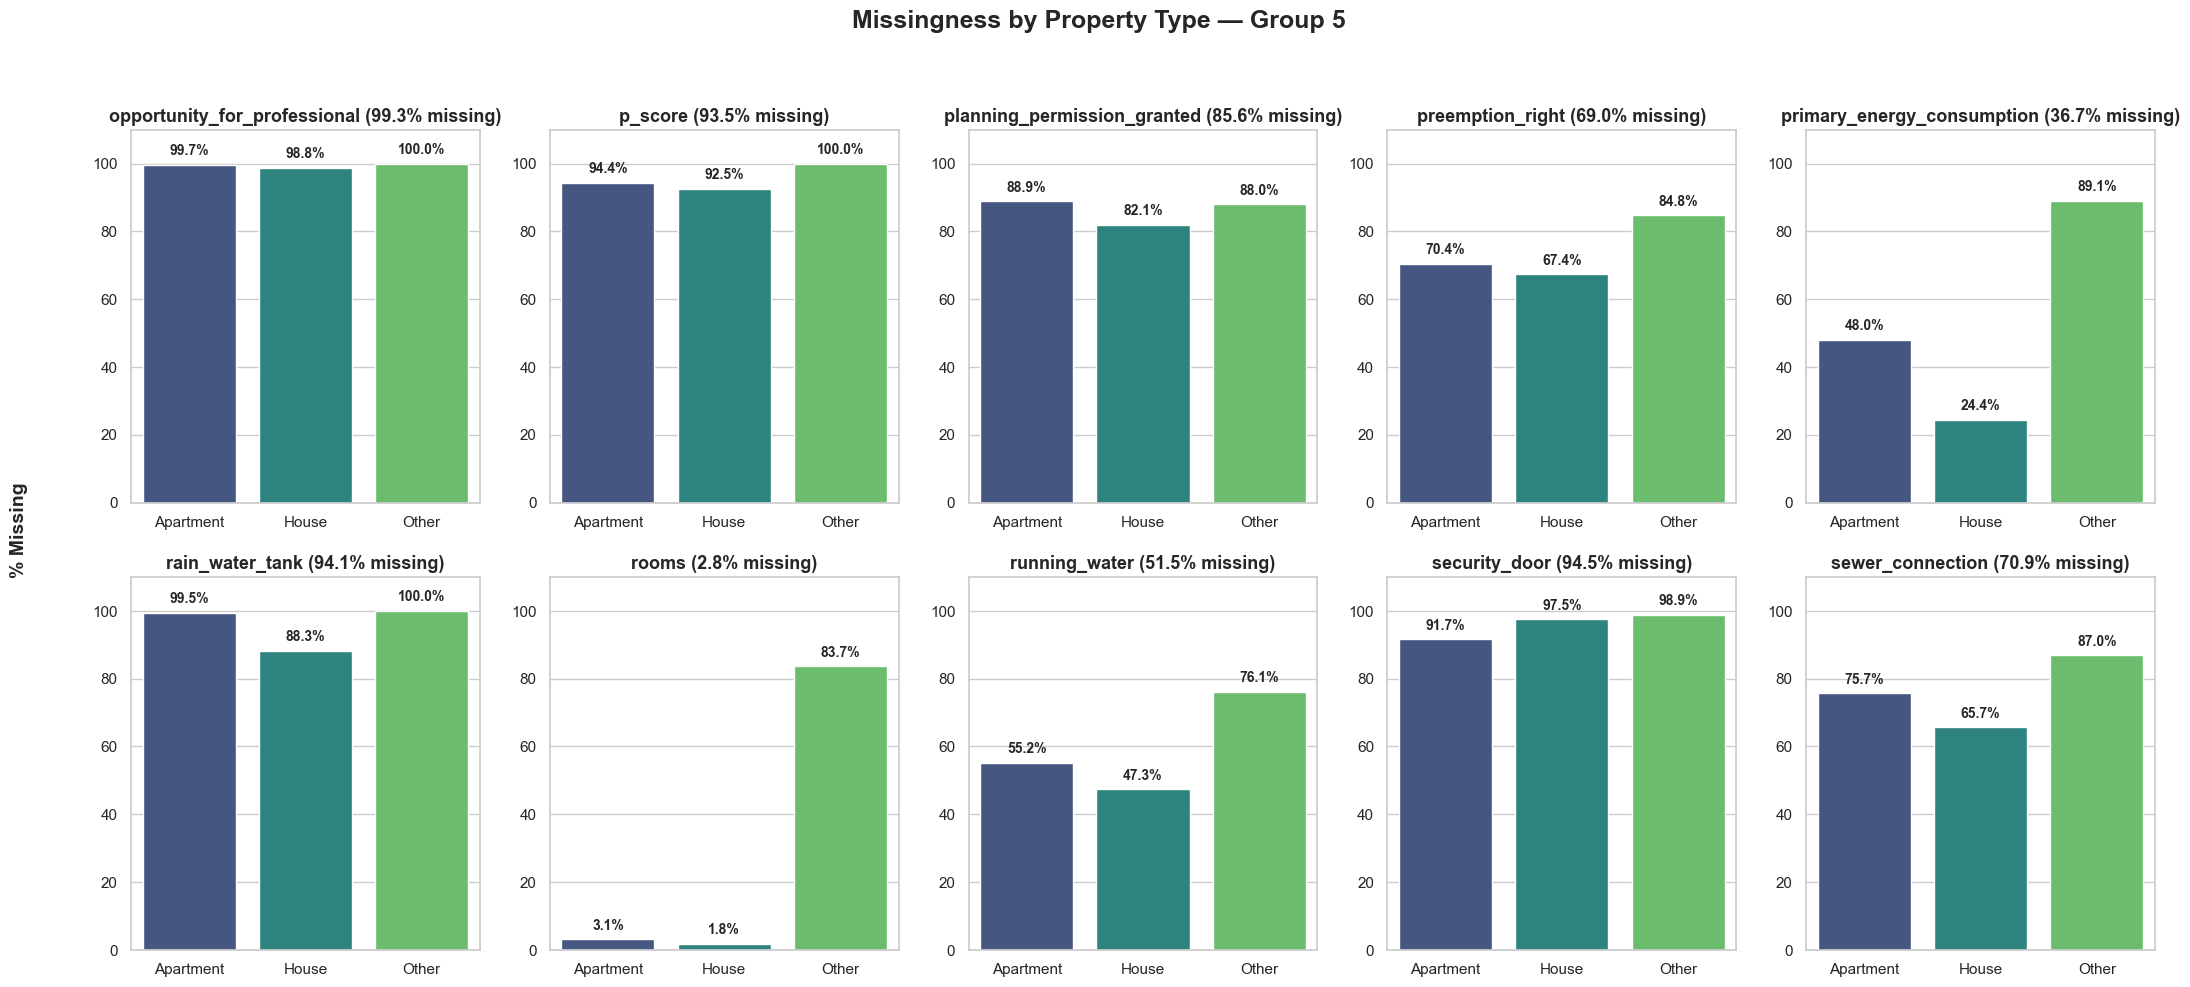

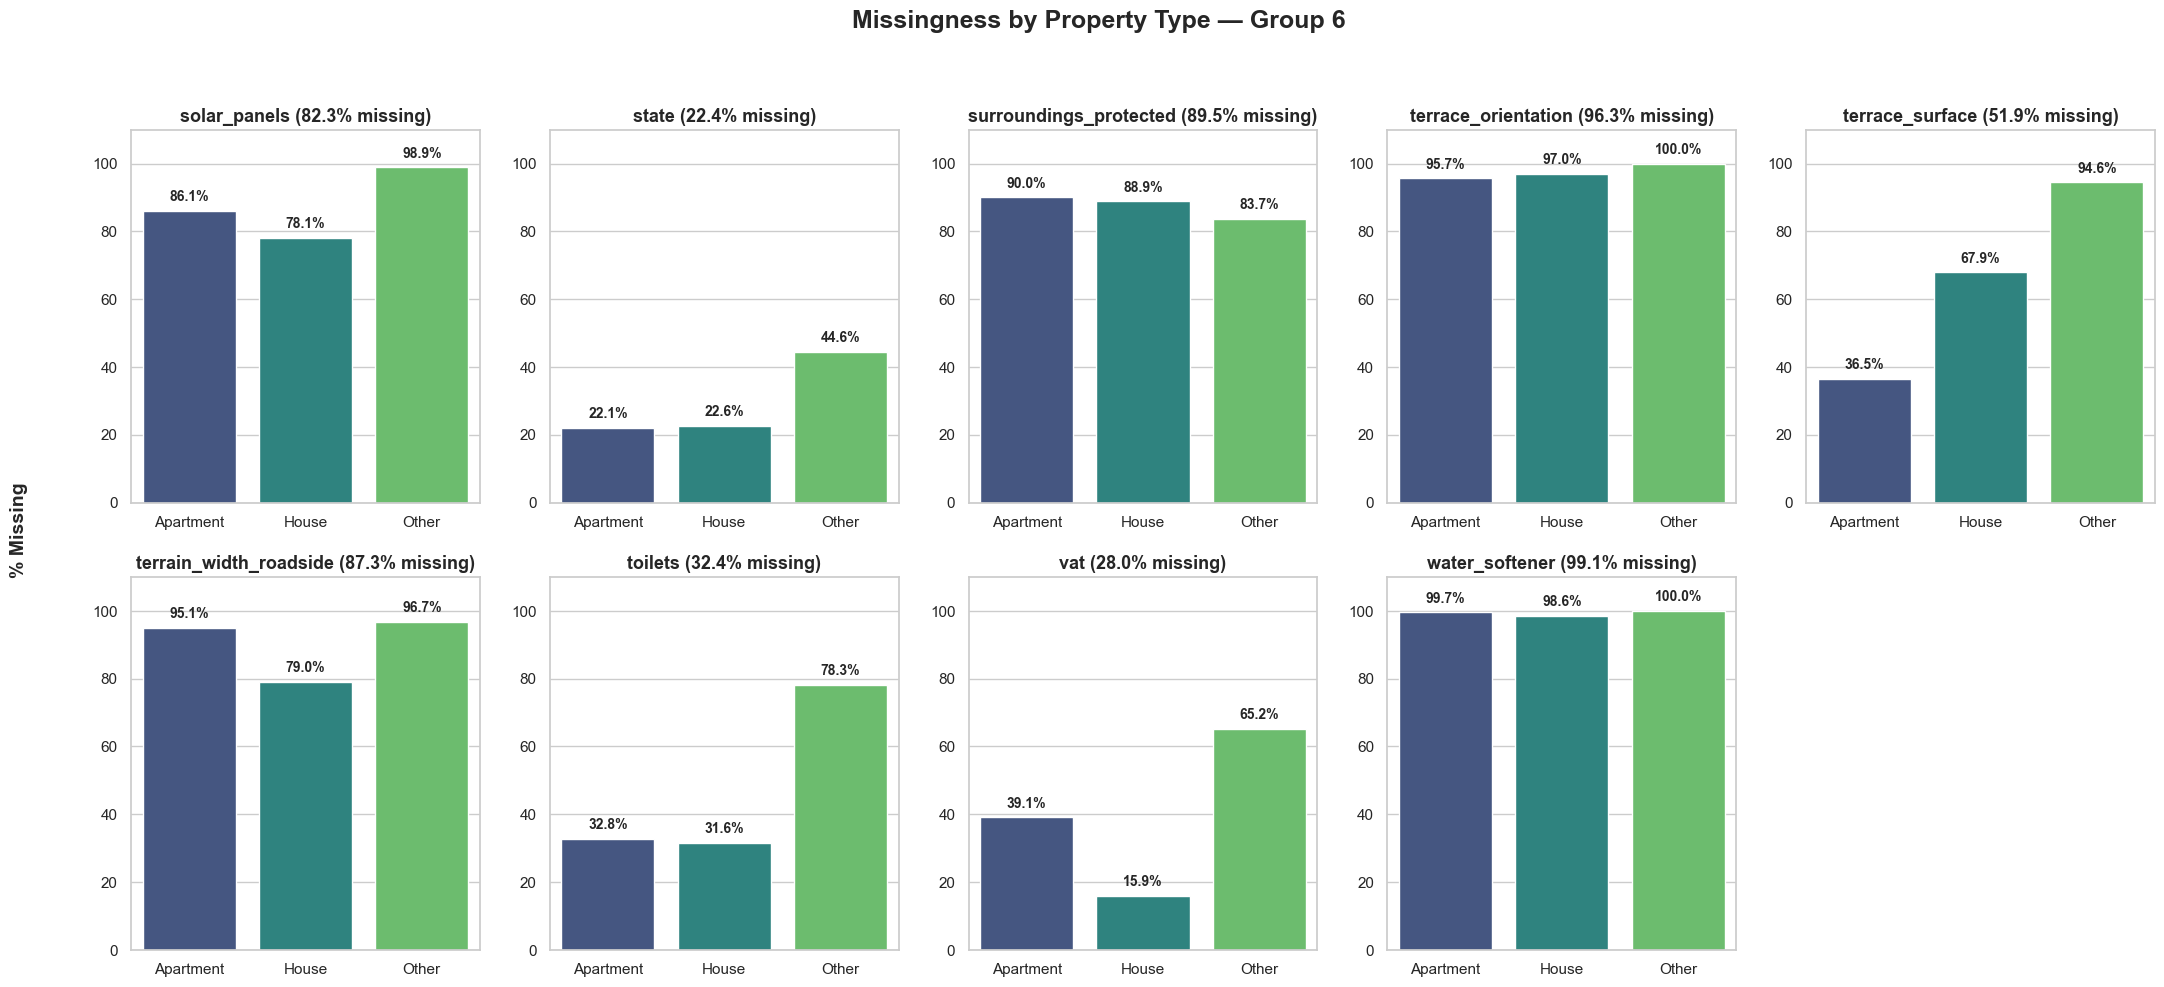

In [123]:
# ----------------------------------------
# 1. Select columns with missing values but NOT 100% missing
# ----------------------------------------
cols_with_missing = [
    col for col in df_clean.columns
    if 0 < df_clean[col].isna().sum() < len(df_clean)
]

cols_with_missing = sorted(cols_with_missing)

# ----------------------------------------
# 2. Split into groups of 10
# ----------------------------------------
group_size = 10
groups = [
    cols_with_missing[i:i + group_size]
    for i in range(0, len(cols_with_missing), group_size)
]

# ----------------------------------------
# 3. Plot each group in a 2×5 grid
# ----------------------------------------
for gi, group_cols in enumerate(groups):

    fig, axes = plt.subplots(2, 5, figsize=(22, 10))
    axes = axes.flatten()

    for ax, col in zip(axes, group_cols):

        # Overall missing % for the column
        overall_missing_pct = df_clean[col].isna().mean() * 100

        temp = pd.DataFrame({
            "property_type": df_clean["property_type"],
            f"{col}_missing": df_clean[col].isna().astype(int)
        })

        ct = (
            pd.crosstab(temp["property_type"], temp[f"{col}_missing"], normalize="index")
            .rename(columns={0: "Present", 1: "Missing"})
            * 100
        )

        sns.barplot(
            data=ct.reset_index(),
            x="property_type",
            y="Missing",
            hue="property_type",
            palette="viridis",
            dodge=False,
            legend=False,
            ax=ax
        )

        # Add values on top of bars
        for i, row in ct.reset_index().iterrows():
            ax.text(
                i,
                row["Missing"] + 2,
                f"{row['Missing']:.1f}%",
                ha="center",
                va="bottom",
                fontsize=10,
                fontweight="bold"
            )

        # Title with overall missing % (bold + larger)
        ax.set_title(
            f"{col} ({overall_missing_pct:.1f}% missing)",
            fontsize=13,
            fontweight='bold'
        )

        # Remove subplot axis labels (global label will be used)
        
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_ylim(0, 110)

    # Remove empty axes (if fewer than 10)
    for j in range(len(group_cols), len(axes)):
        fig.delaxes(axes[j])

    # Global Y-axis label outside grid
    fig.text(
        0.005,
        0.5,
        "% Missing",
        va='center',
        rotation='vertical',
        fontsize=14,
        fontweight='bold'
    )

    # Global title
    plt.suptitle(
        f"Missingness by Property Type — Group {gi+1}",
        fontsize=18,
        fontweight="bold",
        y=1.02
    )

    # Adjust layout to prevent overlaps
    plt.subplots_adjust(left=0.06, right=0.98, top=0.90, bottom=0.08)

    plt.show()


### Other type:

As we can see from all the graphs,“Other” type has the highest missingness

Most other property_type are:

- Business surfaces

- Office spaces

- development site

- Total of 92 values  ===> drop these values

### Missing values more than 80% : drop unless structurally meaningful

- parking_places_outdoor

- wash_room

- front_facade_orientation

- diningrooms

- parking_places_indoor

- certification_gasoil_tank

- opportunity_for_professional

- water_softener

- garden_orientation

- low_energy

- maintenance_cost

- terrace_orientation

- security_door

- rain_water_tank

- p_score

- g_score

- air_conditioning

- surroundings_protected

- heat_pump

- alarm

- terrain_width_roadside

- planning_permission_granted

- frontage_width

- solar_panels

- kitchen_type

- garden_surface

===> drop 

### Missing values in 60–80% range:

- kitchen_surface ===> kitchen_surface_house & keep missing values as separate category

- entry_phone ===> entry_phone_apartment & keep missing values as separate category

- co2 ===> co2_house & keep missing values as separate category

- cellar ===> -1, 0, 1 (keep missing values as separate category)

- sewer_connection ===> -1, 0, 1 (keep missing values as separate category)

- attic ===> attic_house & keep missing values as separate category
 
- has_swimming_pool ===> -1, 0, 1 (keep missing values as separate category)

- preemption_right ===> -1, 0, 1 (keep missing values as separate category)

- cadastral_income ===> cadastral_income_house & keep missing values as separate category

- has_equipped_kitchen ===> keep missing values as separate category

- access_disabled ===> -1, 0, 1 (keep missing values as separate category)

- living_room_surface ===> keep missing values as separate category



### Missing values in 40–60% range: 

- land_surface ===> land_surface_house & keep missing values as separate category

- apartement_floor ===> apartement_floor_apartement & keep missing values as separate category

- availability  ===> drop:  missing values and date_time values

- certification_electrical_installation ===> -1, 0, 1 (keep missing values as separate category)

- glazing_type ===> keep missing values as separate category

- garage ===> -1, 1 (keep missing values as separate category)

- terrace_surface  ===> terrace_surface_apartement & keep missing values as separate category

- running_water ===> -1, 0, 1 (keep missing values as separate category)

- number_floors ===> number_floors_apartement & keep missing values as separate category

- build_year keep missing values as separate category

- is_furnished ===> -1, 0, 1 (keep missing values as separate category)

### Missing values less than 40% range: 

- leased ===> -1, 0, 1 (keep missing values as separate category)

- primary_energy_consumption ===> keep missing values as separate category

- heating_type ===> keep missing values as separate category

- toilets ===> keep missing values as separate category

- elevator ===> keep missing values as separate category

- facades_number ===> keep missing values as separate category

- vat  ===>  drop,  16800 No and rest missing

- state ===> encode and keep missing values as separate category

- bathrooms ===> keep missing values as separate category

- has_garden ===> -1, 0, 1 (keep missing values as separate category)

- has_terrace ===> -1, 0, 1 (keep missing values as separate category)

- area ===> keep missing values as separate category

- rooms ===> keep missing values as separate category
 
- flooding_area_type ===> -1, 0, 1 (keep missing values as separate category)

- demarcated_flooding_area ===> drop : lot of (information not available)

- price

- property_subtype

- postal_code

- locality

- property_type

In [124]:
# =========================================================
# 1. START FROM df_clean AND KEEP ONLY HOUSE + APARTMENT
# =========================================================
df_clean_filtered_missing = df_clean[df_clean["property_type"].isin(["House", "Apartment"])].copy()



# =========================================================
# 2. DROP COLUMNS  MARKED AS NON-USEFUL
# =========================================================
cols_to_drop = [
    "parking_places_outdoor", "wash_room", "front_facade_orientation", "diningrooms",
    "parking_places_indoor", "certification_gasoil_tank", "opportunity_for_professional",
    "water_softener", "garden_orientation", "low_energy", "maintenance_cost",
    "terrace_orientation", "security_door", "rain_water_tank", "p_score", "g_score",
    "air_conditioning", "surroundings_protected", "heat_pump", "alarm",
    "terrain_width_roadside", "planning_permission_granted", "frontage_width",
    "solar_panels", "kitchen_type", "garden_surface", "vat", "demarcated_flooding_area",
    "availability", "url", "property_id"
]

df_clean_filtered_missing.drop(columns=cols_to_drop, inplace=True, errors="ignore")



# =========================================================
# 3. RENAME COLUMNS ACCORDING TO THE SPECIFICATIONS
# =========================================================

# House-specific
df_clean_filtered_missing.rename(columns={
    "kitchen_surface": "kitchen_surface_house",
    "land_surface": "land_surface_house",
    "co2": "co2_house",
    "cadastral_income": "cadastral_income_house",
    "attic": "attic_house",
}, inplace=True)

# Apartment-specific
df_clean_filtered_missing.rename(columns={
    "entry_phone": "entry_phone_apartment",
    "apartement_floor": "apartement_floor_apartment",
    "terrace_surface": "terrace_surface_apartment",
    "number_floors": "number_floors_apartment",
}, inplace=True)



# =========================================================
# 4. ENCODE BINARY / BOOLEAN FIELDS WITH MISSING AS -1
#    {1, 0, -1}  → missing = -1
# =========================================================
binary_cols = [
    "cellar", "sewer_connection", "has_swimming_pool",
    "preemption_right", "access_disabled", "running_water",
    "is_furnished", "garage", "leased", "has_garden",
    "has_terrace"
]

for col in binary_cols:
    df_clean_filtered_missing[col] = df_clean_filtered_missing[col].map({1.0: 1, 0.0: 0})
    df_clean_filtered_missing[col] = df_clean_filtered_missing[col].fillna(-1).astype(int)



# =========================================================
# 5. KEEP MISSING VALUES AS -1 FOR NUMERIC FEATURES
# =========================================================
numeric_keep_missing = [
    "kitchen_surface_house", "living_room_surface",
    "land_surface_house", "apartement_floor_apartment",
    "number_floors_apartment"
]

for col in numeric_keep_missing:
    df_clean_filtered_missing[col] = df_clean_filtered_missing[col].fillna(-1)



# =========================================================
# 6. KEEP MISSING AS CATEGORY ("Missing") FOR CATEGORICAL FIELDS
# =========================================================
categorical_keep_missing = [
    "has_equipped_kitchen",
    "glazing_type",
    "heating_type",
    "state",
]

for col in categorical_keep_missing:
    df_clean_filtered_missing[col] = df_clean_filtered_missing[col].astype("category")
    df_clean_filtered_missing[col] = df_clean_filtered_missing[col].cat.add_categories("Missing")
    df_clean_filtered_missing[col] = df_clean_filtered_missing[col].fillna("Missing")

# =========================================================
# 7. Encode state
# =========================================================
state_grouped_mapping = {
    # Group 0 – Needs renovation
    "To renovate": 0,
    "To be renovated": 0,
    "To restore": 0,
    "To demolish": 0,

    # Group 1 – Under construction
    "Under construction": 1,

    # Group 2 – Normal/Good
    "Normal": 2,

    # Group 3 – Excellent/Renovated
    "Fully renovated": 3,
    "Excellent": 3,

    # Group 4 – New
    "New": 4,

    # Missing
    "Missing": -1
}

# First fix missing values
df_clean_filtered_missing["state"] = (
    df_clean_filtered_missing["state"]
    .fillna("Missing")
    .map(state_grouped_mapping)
)
# =========================================================
# 7. Encode state
# =========================================================
kitchen_equipped_mapping = {
    "Missing": -1,
    "Not equipped": 0,
    "Partially equipped": 1,
    "Fully equipped": 2,
    "Super equipped": 3
}

# Ensure missing values are explicitly labeled first
df_clean_filtered_missing["has_equipped_kitchen"] = (
    df_clean_filtered_missing["has_equipped_kitchen"]
    .astype("string")
    .fillna("Missing")
    .map(kitchen_equipped_mapping)
)

# =========================================================
# 7. Encode glazing_type
# =========================================================
glazing_mapping = {
    "Missing": -1,
    "Simple glass": 0,
    "Double glass": 1,
    "Triple glass": 2
}

# Ensure it's clean string and missing is explicit
df_clean_filtered_missing["glazing_type"] = (
    df_clean_filtered_missing["glazing_type"]
    .astype("string")
    .fillna("Missing")
    .map(glazing_mapping)
)

# =========================================================
# 7. Encode heating_type
# =========================================================
heating_mapping = {
    "Missing": -1,
    "Not specified": -1,
    "Coal": 0,
    "Wood": 1,
    "Fuel oil": 2,
    "Gas": 3,
    "Hot air": 4,
    "Electricity": 5,
    "Solar energy": 6
}
df_clean_filtered_missing["heating_type"] = (
    df_clean_filtered_missing["heating_type"]
    .map(heating_mapping)
)

# =========================================================
# 8. ENCODE certification_electrical_installation {1,0,-1}
# =========================================================
df_clean_filtered_missing["certification_electrical_installation"] = (
    df_clean_filtered_missing["certification_electrical_installation"].map({
        "yes, certificate in accordance": 1,
        "No, certificate does not comply": 0
    })
)

df_clean_filtered_missing["certification_electrical_installation"] = (
    df_clean_filtered_missing["certification_electrical_installation"].fillna(-1).astype(int)
)


# =========================================================
# 9. KEEP MISSING AS -1 FOR KEY NUMERIC FIELDS USED IN MODELS
# =========================================================
numeric_key_fields = [
    "primary_energy_consumption", "build_year", "bathrooms",
    "elevator", "facades_number", "area", "rooms", "terrace_surface_apartment",
    "co2_house","attic_house", "entry_phone_apartment", "cadastral_income_house",
    "toilets"
]

for col in numeric_key_fields:
    df_clean_filtered_missing[col] = df_clean_filtered_missing[col].fillna(-1)



# =========================================================
# 10. flooding_area_type: treat missing as its own category
# =========================================================
df_clean_filtered_missing["flooding_area_type"] = (
    df_clean_filtered_missing["flooding_area_type"].map({
        "no flooding area": 1,
        "Low risk": 1,
        "(information not available)": 0
    })
)

df_clean_filtered_missing["flooding_area_type"] = (
    df_clean_filtered_missing["flooding_area_type"].fillna(-1).astype(int)
)

# =========================================================
# 11. FINAL OUTPUT DATAFRAME
# =========================================================
df_clean_filtered_missing.reset_index(drop=True, inplace=True)

print("Final cleaned dataset shape:", df_clean_filtered_missing.shape)
df_clean_filtered_missing.head()


Final cleaned dataset shape: (23228, 40)


,price,rooms,area,state,facades_number,is_furnished,has_terrace,has_garden,has_swimming_pool,has_equipped_kitchen,...,entry_phone_apartment,access_disabled,apartement_floor_apartment,number_floors_apartment,toilets,cadastral_income_house,property_subtype,postal_code,locality,property_type
0,269000.0,1.0,51.0,-1,-1.0,0,1,0,-1,-1,...,-1.0,-1,-1.0,-1.0,-1.0,-1.0,apartment,2600,berchem,Apartment
1,299000.0,2.0,79.0,2,2.0,0,1,0,-1,-1,...,-1.0,-1,2.0,-1.0,1.0,-1.0,apartment,2050,antwerp,Apartment
2,359000.0,3.0,110.0,-1,-1.0,0,1,0,-1,-1,...,-1.0,-1,2.0,-1.0,1.0,-1.0,apartment,2610,wilrijk,Apartment
3,239000.0,2.0,84.0,2,2.0,0,1,0,-1,-1,...,-1.0,-1,5.0,-1.0,-1.0,-1.0,apartment,2060,antwerp,Apartment
4,189000.0,2.0,80.0,2,2.0,0,0,0,-1,-1,...,-1.0,-1,1.0,-1.0,-1.0,-1.0,apartment,2610,wilrijk,Apartment


## What variables are most subject to outliers? 

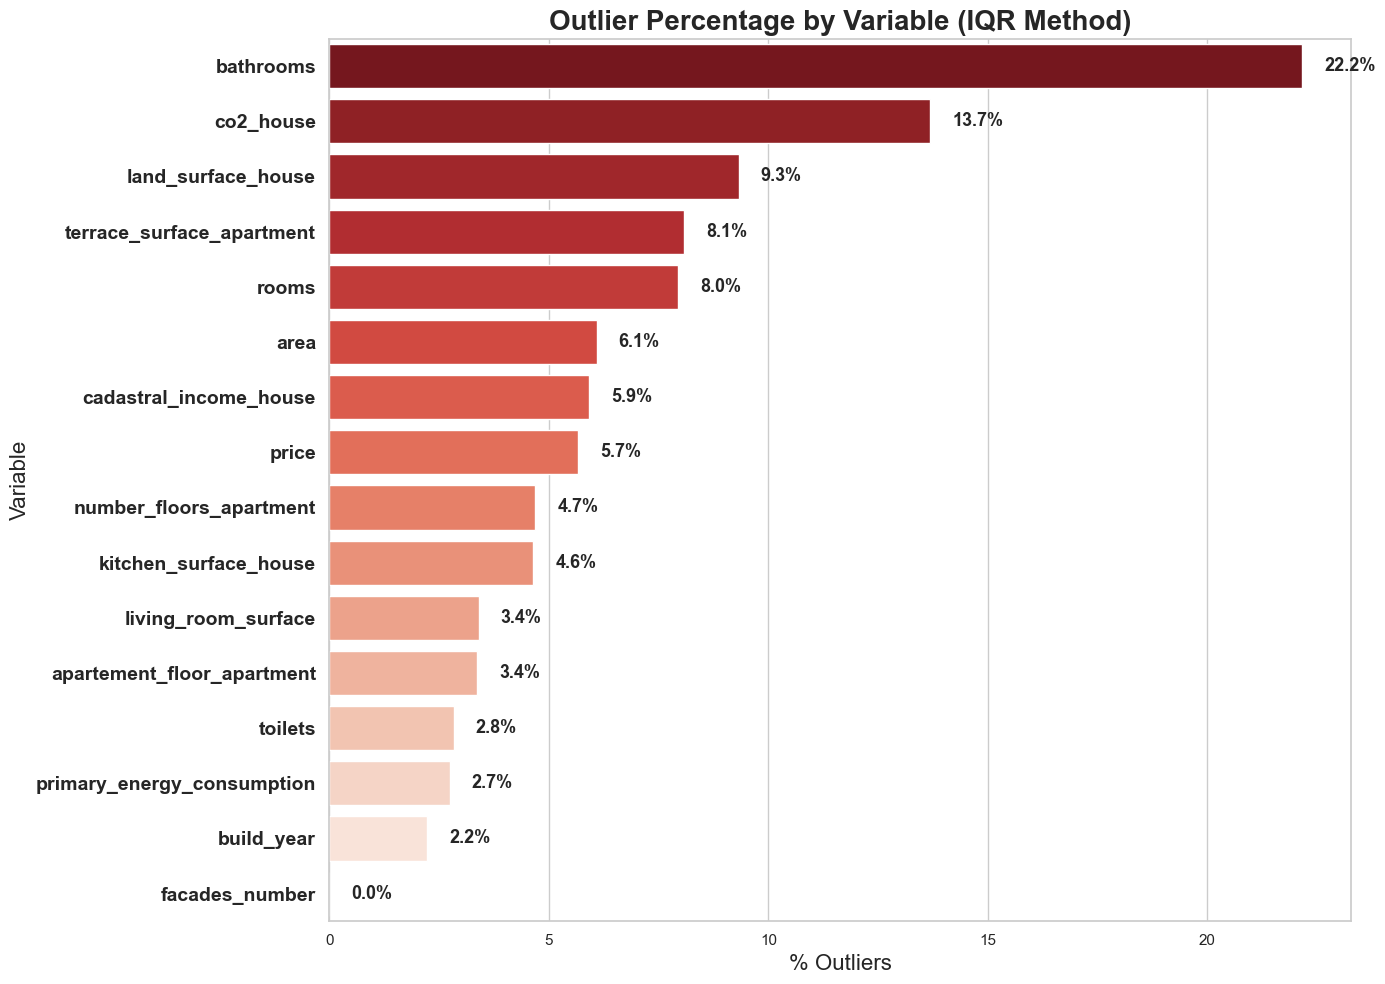

In [125]:
# =========================================================
# 1. Select NUMERIC columns only
# =========================================================
numeric_cols = df_clean_filtered_missing.select_dtypes(include=[np.number]).columns.tolist()

# Keep EXACTLY your exclusion list (these should NOT be tested for outliers)
cols_to_exclude = [
    "postal_code",
    "state",
    "is_furnished",
    "has_terrace",
    "has_garden",
    "has_swimming_pool",
    "has_equipped_kitchen",
    "cellar",
    "sewer_connection",
    "preemption_right",
    "access_disabled",
    "running_water",
    "leased",
    "garage",
    "heating_type",
    "certification_electrical_installation",
    "preemption_right",
    "flooding_area_type",
    "attic_house",
    "entry_phone_apartment",
    "glazing_type",
    "elevator",
    "property_subtype",
    "property_type",
    "locality"
]

# Filter only numeric variables we want to test
numeric_cols = [c for c in numeric_cols if c not in cols_to_exclude]


# =========================================================
# 2. Function to compute outlier % (IQR Method)
# =========================================================
def outlier_ratio(series):
    series = series.replace(-1, np.nan)  # remove special missing codes
    series = series.dropna()
    if series.empty:
        return 0.0

    Q1 = np.percentile(series, 25)
    Q3 = np.percentile(series, 75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = ((series < lower) | (series > upper)).sum()
    return outliers / len(series) * 100


# =========================================================
# 3. Compute outlier percentages
# =========================================================
outlier_stats = {
    col: outlier_ratio(df_clean_filtered_missing[col])
    for col in numeric_cols
}

outlier_df = (
    pd.DataFrame.from_dict(outlier_stats, orient="index", columns=["outlier_pct"])
    .sort_values("outlier_pct", ascending=False)
)


# =========================================================
# 4. Plot Outlier Percentages (fixed FutureWarning)
# =========================================================
plt.figure(figsize=(14, 10))

sns.barplot(
    data=outlier_df.reset_index(),
    x="outlier_pct",
    y="index",
    hue="index",             # FIX for seaborn warning
    dodge=False,
    legend=False,
    palette="Reds_r"
)

plt.title("Outlier Percentage by Variable (IQR Method)", fontsize=20, fontweight="bold")
plt.xlabel("% Outliers", fontsize=16)
plt.ylabel("Variable", fontsize=16)

# Use larger, bold variable names
plt.yticks(fontsize=14, fontweight="bold")

# Add labels on each bar
for i, row in outlier_df.reset_index().iterrows():
    plt.text(
        row["outlier_pct"] + 0.5,
        i,
        f"{row['outlier_pct']:.1f}%",
        fontsize=13,
        fontweight="bold",
        va="center"
    )

plt.tight_layout()
plt.show()


## Clustering

In [126]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# --------------------------
# 1. Filter unrealistic values
# --------------------------
df1 = df_clean_filtered_missing[
    (df_clean_filtered_missing["area"] >= 15) &
    (df_clean_filtered_missing["price"] >= 80000) &
    (df_clean_filtered_missing["property_subtype"] != "mixed building")
].copy()

# --------------------------
# 2. Compute price per m²
# --------------------------
df1["price_per_m2"] = df1["price"] / df1["area"]

# --------------------------
# 3. Prepare clustering variables
# --------------------------
features = ["price_per_m2", "price", "area", "rooms"]

df_cluster = df1[features].dropna().copy()

# --------------------------
# 4. Scale
# --------------------------
scaler = StandardScaler()
X = scaler.fit_transform(df_cluster)

# --------------------------
# 5. KMeans (3 clusters)
# --------------------------
kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto")
df_cluster["cluster"] = kmeans.fit_predict(X)

# --------------------------
# 6. Attach labels back
# --------------------------
df1.loc[df_cluster.index, "cluster"] = df_cluster["cluster"]


In [127]:
centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=features
)
print(centers)


   price_per_m2          price        area     rooms
0   4867.130676  941208.824176  262.467033  4.004884
1   2653.882330  311746.512690  157.344927  2.518613


In [128]:
price_bins = centers["price_per_m2"].rank().astype(int) - 1
mapping = dict(zip(price_bins.index, price_bins.values))

df1["luxury_segment"] = df1["cluster"].map(mapping)

df_cluster.groupby("cluster").median()


,price_per_m2,price,area,rooms
cluster,,,,
0,4235.647572,795000.0,198.5,3.0
1,2642.857143,298000.0,115.0,2.0


In [129]:
c0 = df1[df1.cluster == 0]["price_per_m2"].median()
c1 = df1[df1.cluster == 1]["price_per_m2"].median()

df1["is_luxurious"] = (df1["cluster"] == (0 if c0 > c1 else 1))

df1["cluster"].value_counts(normalize=True)*100

cluster
1.0    91.885823
0.0     8.114177
Name: proportion, dtype: float64

In [130]:
df1.groupby("cluster")[["area","rooms","price","price_per_m2"]].median()


,area,rooms,price,price_per_m2
cluster,,,,
0.0,198.5,3.0,795000.0,4235.647572
1.0,115.0,2.0,298000.0,2642.857143


## Skewness 

In [131]:
df = df_clean.copy()

df = df[df["area"] >= 15] #cleaning the unrealistic surfaces - there were some with surface set as 1m2. Setting to 15 as it's within the average minimum surface area 
df= df[df["price"] >=70_000] # cleaning unrealistic prices

df['price_per_m2']=df['price']/df['area']
df['log10_price'] = np.log10(df['price'])
df['log10_price_per_m2']=np.log10(df['price_per_m2'])

In [132]:
df_clustered= df[["area", "rooms",'price']].dropna()
# scale variables (important!)
scaler = StandardScaler()
X = scaler.fit_transform(df_clustered)

# cluster into 2 groups
kmeans = KMeans(n_clusters=2, random_state=42)
df_clustered["cluster"] = kmeans.fit_predict(X)
df = df.merge(df_clustered["cluster"], left_index=True, right_index=True, how="left")

df["property_class"] = df["cluster"].map({0: "luxury", 1: "residential"})

In [133]:
df["property_class"].value_counts(normalize=True)*100

property_class
residential    90.687098
luxury          9.312902
Name: proportion, dtype: float64

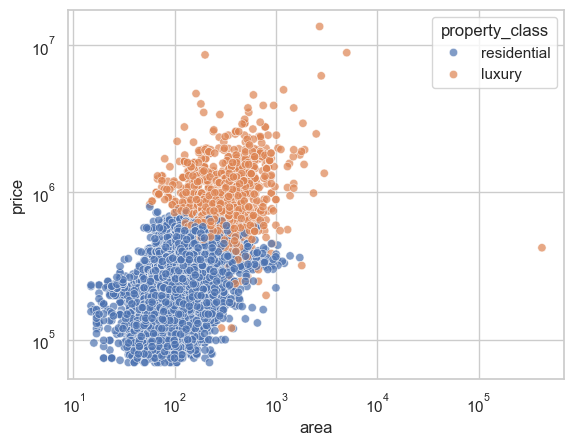

In [134]:
sns.scatterplot(data=df, x="area", y="price", hue="property_class", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.show()


In [135]:
df.groupby("property_class")[["area","rooms","price","price_per_m2"]].median()

,area,rooms,price,price_per_m2
property_class,,,,
luxury,269.0,4.0,769500.0,2815.735472
residential,114.0,2.0,296000.0,2675.675676


We see that despite the luxury class having ~3x the median price of the property, the price of the square meter remains close.

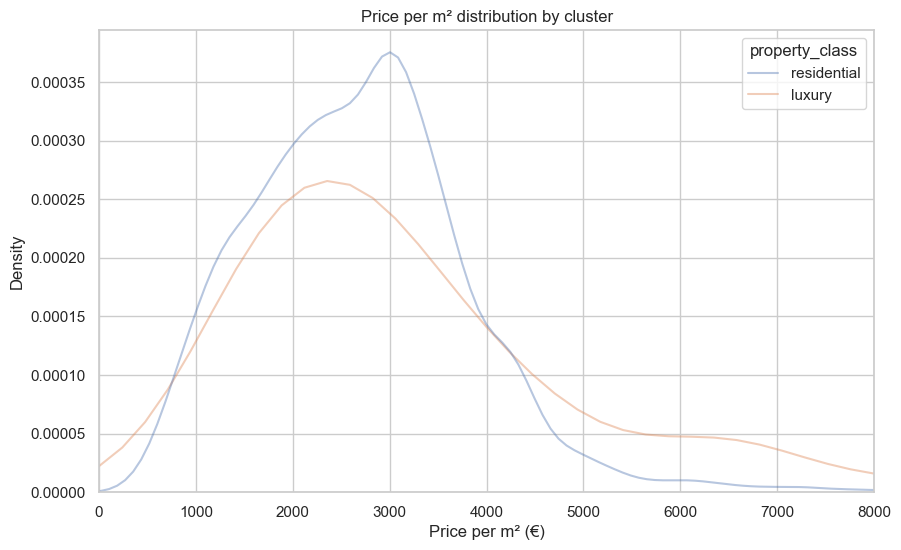

In [136]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=df, x="price_per_m2", hue="property_class", fill=False, common_norm=False, alpha=0.4)
plt.xlim(0,8000)  # adjust as needed
plt.title("Price per m² distribution by cluster")
plt.xlabel("Price per m² (€)")
plt.show()

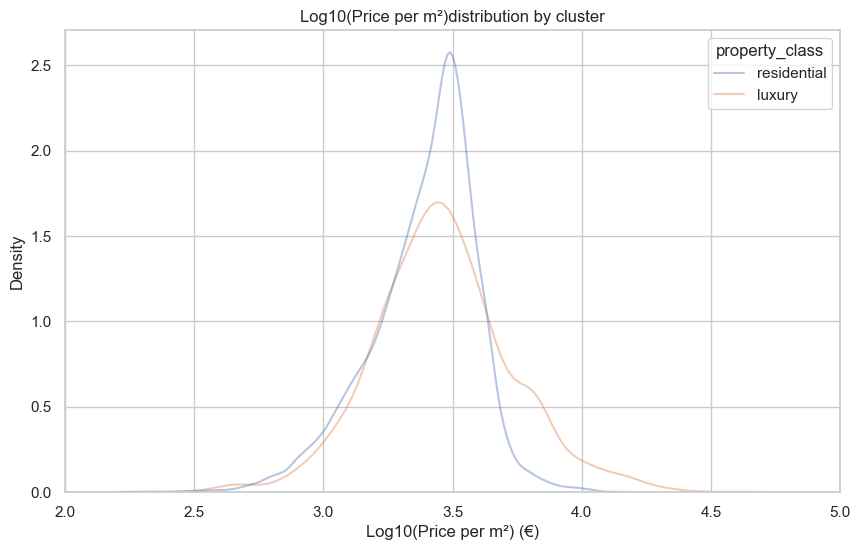

In [137]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=df, x="log10_price_per_m2", hue="property_class", fill=False, common_norm=False, alpha=0.4)
plt.xlim(2,5)  # adjust as needed
plt.title("Log10(Price per m²)distribution by cluster")
plt.xlabel("Log10(Price per m²) (€)")
plt.show()

In [138]:

from scipy.stats import gaussian_kde

def plot_kde(df,column_name,xlim=None):
    data = [df[column_name].dropna()]
    labels = [column_name]
    kde=gaussian_kde(data)
    x = np.linspace(0,8000,num=2000)
    y = kde(x)
    plt.plot(x, y, color=color, label="KDE")


def calculate_fwhm(data,column,xmin=0,xmax=8000,points=3000):

    data=data[column].dropna().values
    kde = gaussian_kde(data)
    #creating x-grid for KDE evaluation
    x = np.linspace(xmin,xmax,points)
    y = kde(x)

    
    y_max=np.max(y)
    half_max = np.max(y) / 2
    idx = np.where(y >= half_max)[0]
    right= x[idx[-1]]
    left= x[idx[0]]
    fwhm=  right-left
    return x,y, y_max, half_max, left,right, fwhm


In [139]:
df_residential_cluster = df[df["cluster"] == 1]
df_luxury_cluster=df[df["cluster"]==0]



calculate_fwhm(df,column='price_per_m2')
calculate_fwhm(df_residential_cluster,column='price_per_m2')
calculate_fwhm(df_luxury_cluster,column='price_per_m2')


(array([0.00000000e+00, 2.66755585e+00, 5.33511170e+00, ...,
        7.99466489e+03, 7.99733244e+03, 8.00000000e+03], shape=(3000,)),
 array([2.23700717e-05, 2.25129910e-05, 2.26565990e-05, ...,
        1.60049499e-05, 1.59710728e-05, 1.59373256e-05], shape=(3000,)),
 np.float64(0.00026556049116484103),
 np.float64(0.00013278024558242051),
 np.float64(1029.6765588529508),
 np.float64(4086.695565188396),
 np.float64(3057.019006335445))

In [140]:
import itertools

def plot_kde_with_fwhm(df, value_col, xmin=0, xmax=8000,
                       cluster_col="property_class",
                       title=""):


    # Automatic distinct colors (infinite cycle)
    color_cycle = itertools.cycle(plt.cm.tab10.colors)

    plt.figure(figsize=(10,6))

    for cl in sorted(df[cluster_col].dropna().unique()):
        subset = df[df[cluster_col] == cl]

        res = calculate_fwhm(subset, column=value_col, xmin=xmin, xmax=xmax)
        if res is None:
            continue

        x, y, y_max, half_max, left, right, fwhm = res
        color = next(color_cycle)

        peak_idx = y.argmax()
        peak_x = x[peak_idx]
        peak_y = y[peak_idx]

        plt.plot(x, y, color=color, label=f"{cluster_col}={cl}")

        # Peak marker
        plt.scatter([peak_x], [peak_y], color="red", s=60)
        
        # Peak label
        plt.annotate(
            f"Peak = {peak_x:.0f} ",
            xy=(peak_x, peak_y),
            xytext=(peak_x, peak_y * 1.12),
            arrowprops=dict(arrowstyle="->", color=color),
            ha="center",
            fontsize=10,
            color=color
        )

        # Half max line
        plt.hlines(half_max, left, right, colors=color, linestyles="dotted", alpha=0.5)

        # FWHM annotation
        mid = (left + right) / 2
        plt.text(
            mid,
            half_max * 1.05,
            f"FWHM = {fwhm:.0f} ",
            ha="center",
            color=color,
            fontsize=10
        )

    plt.xlim(xmin, xmax)
    plt.title(title or f"KDE + FWHM for {value_col}",x=0.65)
    plt.xlabel(value_col)
    plt.ylabel("Density")
    plt.legend()
    plt.show()


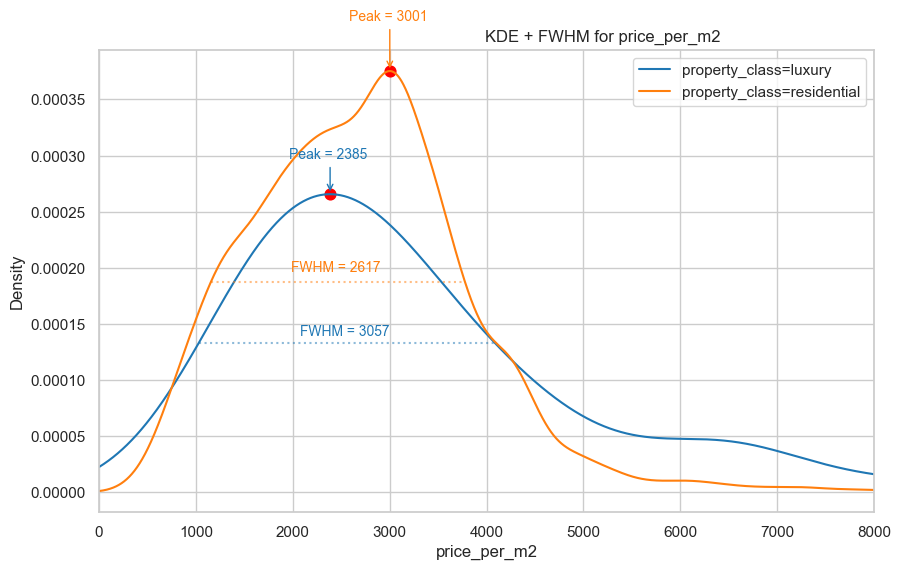

In [141]:
plot_kde_with_fwhm(df,value_col='price_per_m2')


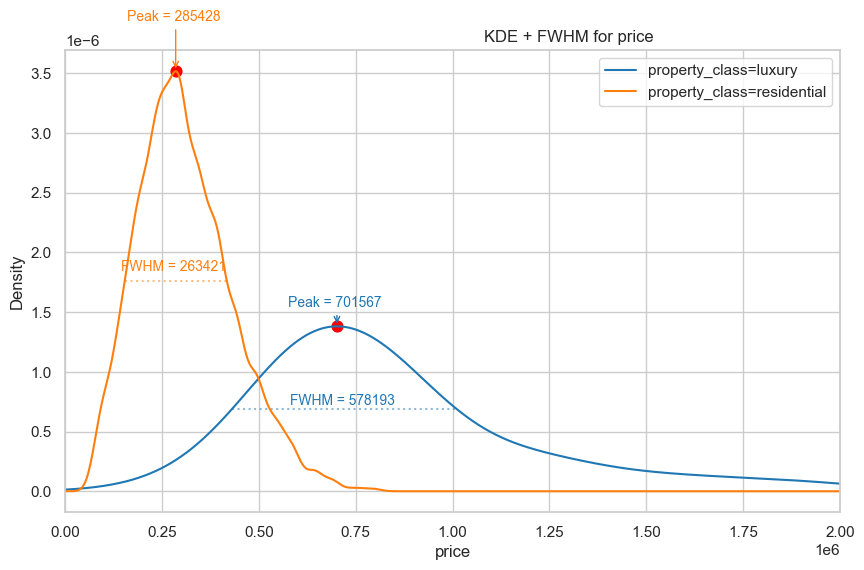

In [142]:
plot_kde_with_fwhm(df,value_col='price',xmin=0,xmax=2_000_000)

Metrics on skewness:

price_per_m2

In [143]:
from scipy.stats import skew

skew_value = skew(df["price_per_m2"].dropna())
print("Skewness of the global dataset:", skew_value)

Skewness of the global dataset: 3.7204387185795897


Luxury cluster:


In [144]:
skew_value = skew(df_residential_cluster["price_per_m2"].dropna())
print("Skewness of the residential dataset:")
print(skew_value)

Skewness of the residential dataset:
1.3997130276327536


Residential cluster:

In [145]:
skew_value = skew(df_luxury_cluster["price_per_m2"].dropna())
print("Skewness of the luxury dataset:")
print(skew_value)


Skewness of the luxury dataset:
3.951747993683755


Price:

In [146]:
skew_value = skew(df["price"].dropna())
print("Skewness of the global dataset:", skew_value)

Skewness of the global dataset: 11.10929777579365


In [147]:
skew_value = skew(df_residential_cluster["price"].dropna())
print("Skewness of the residential dataset:", skew_value)
print(skew_value)

Skewness of the residential dataset: 0.6018969227919756
0.6018969227919756


In [148]:
skew_value = skew(df_luxury_cluster["price"].dropna())
print("Skewness of the luxury dataset:")
print(skew_value)

Skewness of the luxury dataset:
7.900936709309194


Area:

In [149]:
skew_value = skew(df["area"].dropna())
print("Skewness of the global dataset:", skew_value)

Skewness of the global dataset: 143.11252884024398


In [150]:
skew_value = skew(df_residential_cluster["area"].dropna())
print("Skewness of the residential dataset:")
print(skew_value)


Skewness of the residential dataset:
4.3506716496368565


In [151]:
skew_value = skew(df_luxury_cluster["area"].dropna())
print("Skewness of the luxury dataset:")
print(skew_value)


Skewness of the luxury dataset:
43.32467218995299


The above values as well as information on peak positions and FWHMs lead to a fundamental conclusion: for analysis and for further creating the ML model, big and luxurious properties need to be considered separate, as most of the skewness comes, as suspected, from these properties.
The "regular" residential segment, although improved, remains highly skewed. This suggests the need for a more advanced strategy (for example, splitting the data into more clusters, using a different clustering algorithm or clustering by different features).
This will be tackled in detail the next phase of the project.

## Features driving the price:

#### Apartments vs houses

Property types found: ['Apartment' 'House']


C:\Users\Chaib\AppData\Local\Temp\ipykernel_624\975046212.py:75: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




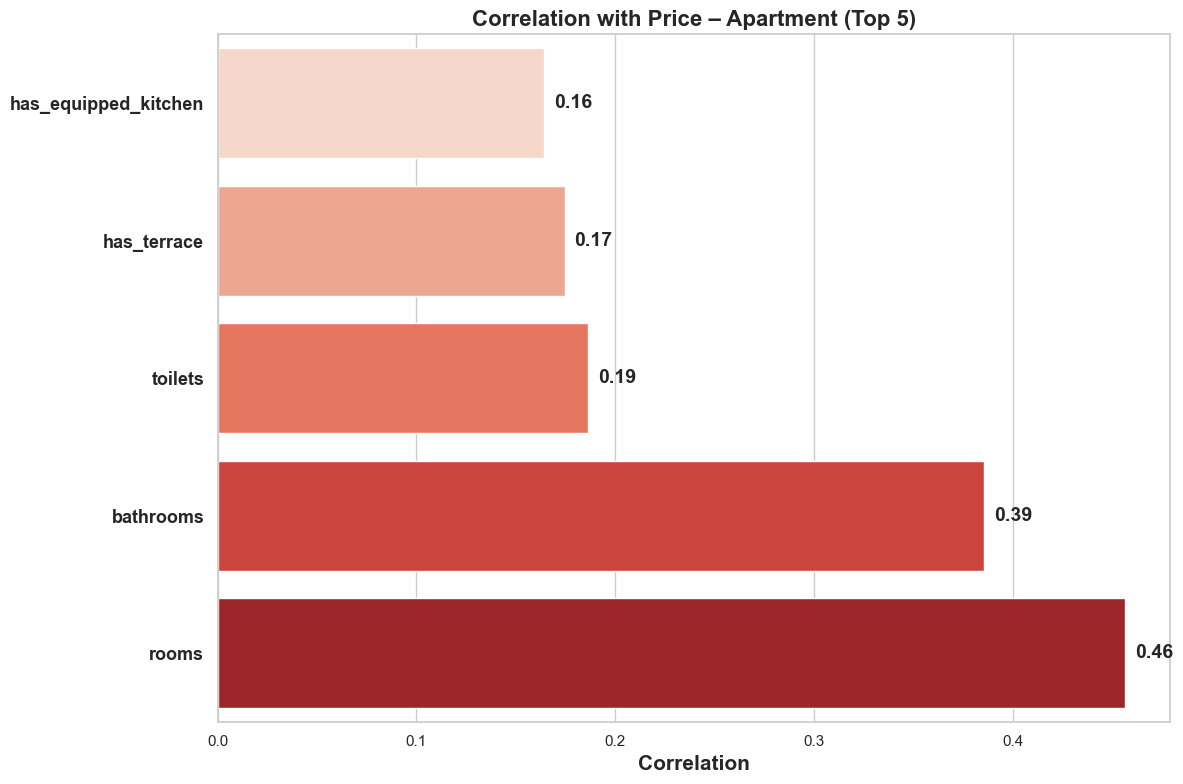

C:\Users\Chaib\AppData\Local\Temp\ipykernel_624\975046212.py:75: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




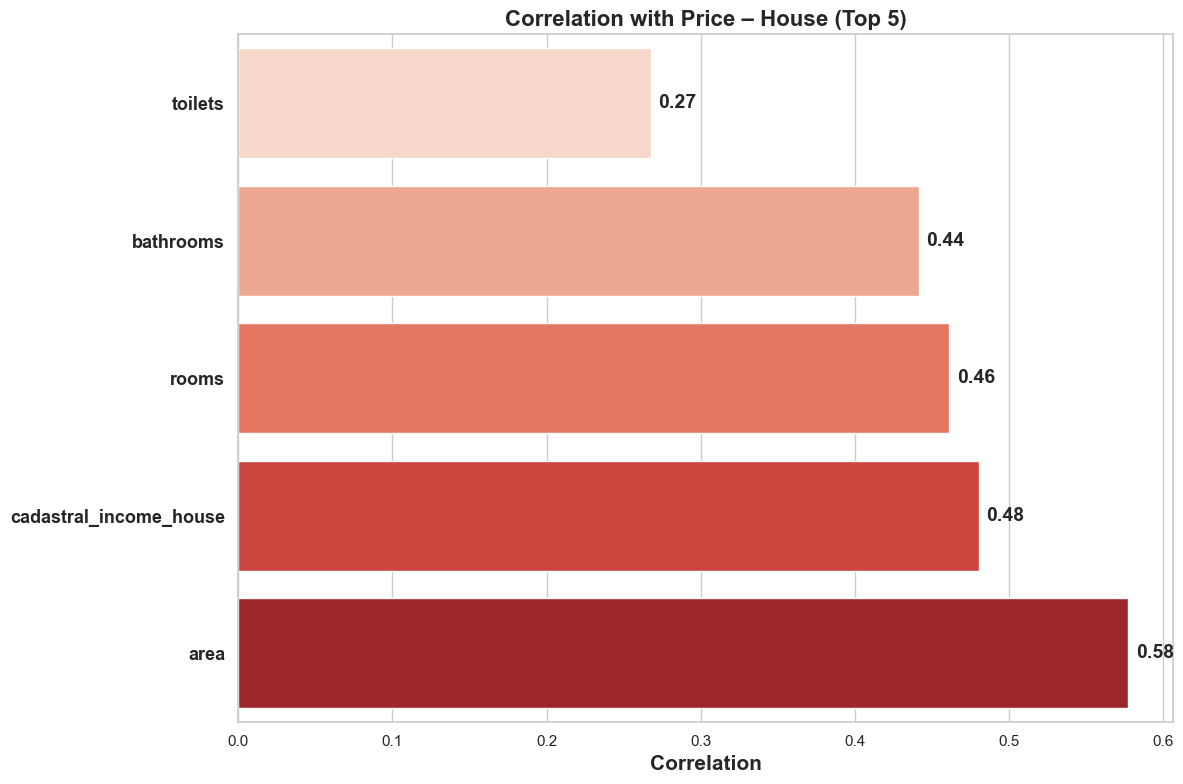

In [152]:
# ---------------------------------------------------------
# 1. Base DF
# ---------------------------------------------------------

df = df1.copy()

# Make sure property_type is clean
df = df[df["property_type"].notna()]

# ---------------------------------------------------------
# 2. Clean numeric feature list
# ---------------------------------------------------------

exclude = [
    "price",
    "price_per_m2",   # keep only real one
    "cluster",
    "luxury_segment",
    "is_luxurious"
]

num_features = [
    col for col in df.columns
    if df[col].dtype != "object" and col not in exclude
]

# ---------------------------------------------------------
# 3. Function to compute top correlations for each property type
# ---------------------------------------------------------

def compute_top_corr(df_sub, k=5):
    # drop price rows that are NaN
    df_sub = df_sub[df_sub["price"].notna()]
    
    corr = df_sub[num_features + ["price"]].corr()["price"]
    corr = corr.drop("price", errors="ignore")

    # drop NaN correlations
    corr = corr.dropna()

    # handle zero-variance columns (corr = NaN)
    corr = corr[corr.abs() > 0]

    # top-k by absolute value
    corr = corr.reindex(corr.abs().sort_values(ascending=False).index[:k])
    corr = corr.sort_values()  # small → large
    return corr

# ---------------------------------------------------------
# 4. Get list of property types
# ---------------------------------------------------------

property_types = df["property_type"].unique()

print("Property types found:", property_types)

# ---------------------------------------------------------
# 5. Generate a plot for each property type
# ---------------------------------------------------------

for pt in property_types:
    df_pt = df[df["property_type"] == pt]
    corr_pt = compute_top_corr(df_pt, k=5)

    if corr_pt.empty:
        print(f"\nNo valid correlations for property_type = {pt}. Skipping.")
        continue

    # Colors
    colors = sns.color_palette("Reds", n_colors=len(corr_pt))

    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 8))

    sns.barplot(
        x=corr_pt.values,
        y=corr_pt.index,
        palette=colors
    )

    plt.title(f"Correlation with Price – {pt.title()} (Top 5)", fontsize=16, weight="bold")
    plt.xlabel("")
    plt.ylabel("")

    # Bold labels
    plt.yticks(fontsize=13, weight="bold")

    # Value labels
    for i, v in enumerate(corr_pt.values):
        plt.text(
        v + 0.005,
        i,
        f"{v:.2f}",
        va="center",
        fontsize=14,      # increase text size
        fontweight="bold" # make it bold
    )

    plt.xlabel("Correlation", fontsize=15, weight="bold")
    plt.tight_layout()
    plt.show()


C:\Users\Chaib\AppData\Local\Temp\ipykernel_624\1131139291.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




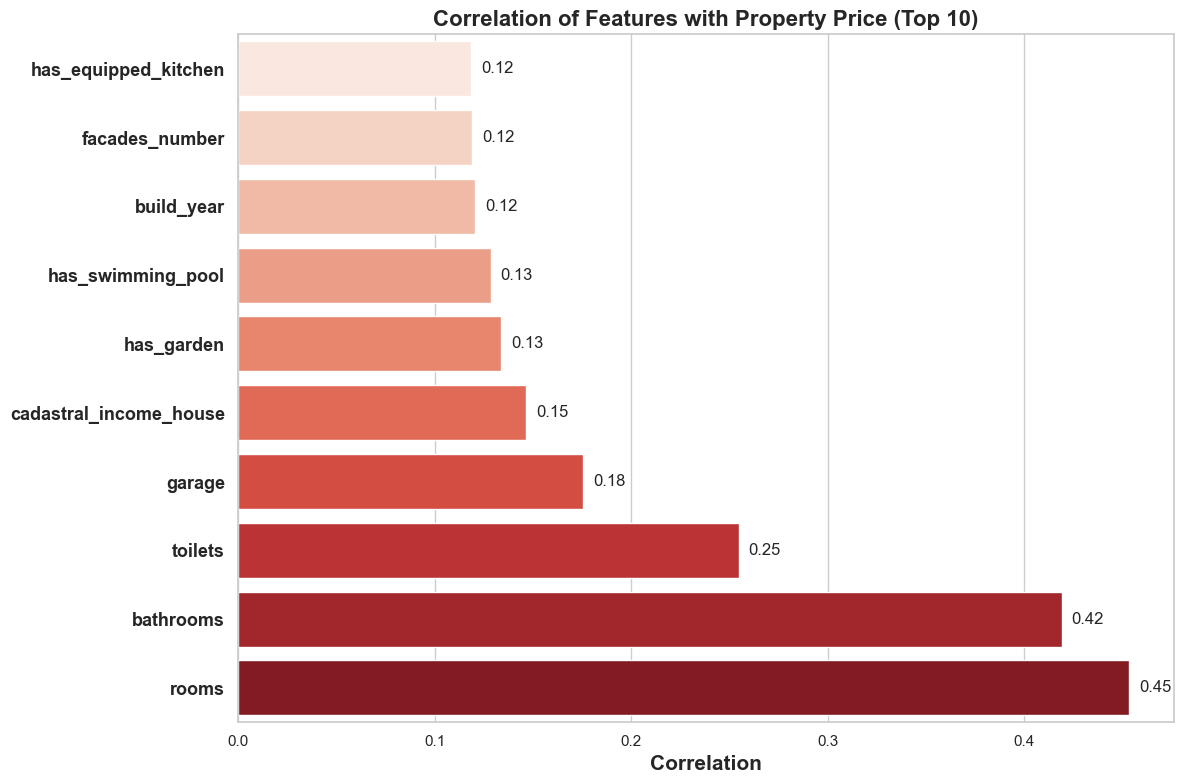

In [153]:
# ---------------------------------------------------------
# 1. BASE DF
# ---------------------------------------------------------

df = df1.copy()

# ---------------------------------------------------------
# 2. CLEAN NUMERIC FEATURES (NO LOGS)
# ---------------------------------------------------------

exclude = [
    "price",
    "price_per_m2",   # keep only real one
    "cluster",
    "luxury_segment",
    "is_luxurious"
]

num_features = [
    col for col in df.columns
    if df[col].dtype != "object" and col not in exclude
]

# ---------------------------------------------------------
# 3. COMPUTE CORRELATION WITH PRICE
# ---------------------------------------------------------

corr_series = df[num_features + ["price"]].corr()["price"]

corr_series = corr_series.drop("price", errors="ignore")
corr_series = corr_series.dropna()  # remove NaN correlations

# Select Top 10 strongest absolute correlations
corr_top = corr_series.reindex(
    corr_series.abs().sort_values(ascending=False).index[:10]
)

# Sort small → large for nicer horizontal bars
corr_top = corr_top.sort_values()

# ---------------------------------------------------------
# 4. COLOR PALETTE
# ---------------------------------------------------------

colors = sns.color_palette("Reds", n_colors=len(corr_top))

# ---------------------------------------------------------
# 5. PLOT
# ---------------------------------------------------------

sns.set_style("whitegrid")

plt.figure(figsize=(12, 8))

sns.barplot(
    x=corr_top.values,
    y=corr_top.index,
    palette=colors
)

plt.title("Correlation of Features with Property Price (Top 10)", fontsize=16, weight="bold")
plt.xlabel("")
plt.ylabel("")

# Bold feature names
plt.yticks(fontsize=13, weight="bold")

# Add correlation values
for i, v in enumerate(corr_top.values):
    plt.text(v + 0.005, i, f"{v:.2f}", va="center", fontsize=12)

plt.xlabel("Correlation", fontsize=15, weight="bold")

plt.tight_layout()
plt.show()


## External factors (GDP)

We wanted to examine what other factors could influence the price of a property. To analyse this we use data from statbel. Let's analyze the relationship between GDP per capita and median house prices at different geographic levels:
- Municipalities (localities)
- Arrondissements
- Provinces

In [154]:
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats

### Load Datasets

In [155]:
# Load property dataset
properties_df = pd.read_csv('../data/cleaned/cleaned_dataset_v4_with_luxury_segment.csv')

# Load median income (GDP) dataset
income_df = pd.read_csv('../data/raw/median_income.csv')

# Load geographic mapping with arrondissement and province info
geo_mapping = pd.read_csv('../data/raw/TF_SOC_POP_STRUCT_2025.csv')

# Load postal code to municipality mapping
postal_codes_df = pd.read_csv('../data/raw/postal-codes-belgium.csv', sep=';', encoding='utf-8-sig')

### Data Cleaning

In [156]:
# Clean income data
income_df['median_income'] = income_df['median_income'].astype(float)

# Standardize municipality names (lowercase for matching)
income_df['municipality_lower'] = income_df['municipality'].str.lower().str.strip()

# Standardize locality names (lowercase for matching)
properties_df['locality_lower'] = properties_df['locality'].str.lower().str.strip()

# Remove rows with missing price or locality
properties_df = properties_df.dropna(subset=['price', 'locality'])

print(f"Properties after cleaning: {properties_df.shape}")
print(f"Number of unique localities: {properties_df['locality_lower'].nunique()}")

Properties after cleaning: (20039, 45)
Number of unique localities: 1251


### Prepare Geographic Mapping

In [157]:
# Step 1: Create postal code to municipality code mapping
postal_lookup = postal_codes_df[['Postal Code', 'Municipality code']].copy()
postal_lookup.columns = ['postal_code', 'municipality_code']
postal_lookup = postal_lookup.drop_duplicates()
postal_lookup['postal_code'] = postal_lookup['postal_code'].astype(str)

# Step 2: Create municipality code (CD_REFNIS) to arrondissement/province mapping from geo_mapping
geo_lookup = geo_mapping[['CD_REFNIS', 'TX_DESCR_NL', 'TX_DESCR_FR', 
                          'TX_ADM_DSTR_DESCR_NL', 'TX_ADM_DSTR_DESCR_FR', 
                          'TX_PROV_DESCR_NL', 'TX_PROV_DESCR_FR']].drop_duplicates()

# Standardize municipality names for matching with income data
geo_lookup['municipality_nl_lower'] = geo_lookup['TX_DESCR_NL'].str.lower().str.strip()
geo_lookup['municipality_fr_lower'] = geo_lookup['TX_DESCR_FR'].str.lower().str.strip()

### Calculate Median House Prices by Municipality

In [158]:
# Calculate median house price by municipality
municipality_prices = properties_df.groupby('locality_lower').agg({
    'price': ['median', 'mean', 'count'],
    'locality': 'first'  # Keep original name
}).reset_index()

# Flatten column names
municipality_prices.columns = ['locality_lower', 'median_price', 'mean_price', 'count', 'locality_original']

# Filter municipalities with at least 5 properties for statistical reliability
municipality_prices = municipality_prices[municipality_prices['count'] >= 5]

print(f"Number of municipalities with 5+ properties: {len(municipality_prices)}")
municipality_prices.head(10)

Number of municipalities with 5+ properties: 536


,locality_lower,median_price,mean_price,count,locality_original
1,aalst,337500.0,368156.765258,213,aalst
3,aarschot,356800.0,339266.666667,6,aarschot
4,aarsele,360000.0,366737.288136,59,aarsele
5,aartrijke,269825.0,277650.000000,6,aartrijke
9,adegem,413500.0,415384.615385,13,adegem
12,agimont,218000.0,212285.777778,9,agimont
16,alleur,292000.0,304837.000000,16,alleur
21,anderlecht,215000.0,262818.918919,37,anderlecht
23,andrimont,230000.0,297278.947368,19,andrimont
24,angleur,307000.0,323936.567164,67,angleur


### Merge Municipality Data with GDP

In [159]:
# NEW MERGING STRATEGY: Use postal codes to get municipality codes, then merge with geographic data

# Step 1: Prepare properties data with postal codes
# Convert postal codes to integers (they're stored as floats like 2660.0)
properties_df['postal_code'] = properties_df['postal_code'].fillna(0).astype(int).astype(str)
properties_df.loc[properties_df['postal_code'] == '0', 'postal_code'] = None

# Step 2: Merge properties with postal code lookup to get municipality codes
properties_with_muni = properties_df.merge(
    postal_lookup,
    on='postal_code',
    how='left'
)

print(f"Properties with municipality codes: {properties_with_muni['municipality_code'].notna().sum()} / {len(properties_with_muni)}")

# Step 3: Merge with geo_lookup to get arrondissement and province
properties_with_geo = properties_with_muni.merge(
    geo_lookup,
    left_on='municipality_code',
    right_on='CD_REFNIS',
    how='left'
)

print(f"Properties with geographic data: {properties_with_geo['TX_ADM_DSTR_DESCR_NL'].notna().sum()} / {len(properties_with_geo)}")

# Step 4: Calculate median house prices by municipality (using municipality_code)
# Only include properties where we have geographic data
properties_with_complete_geo = properties_with_geo[properties_with_geo['TX_ADM_DSTR_DESCR_NL'].notna()].copy()

municipality_prices = properties_with_complete_geo.groupby('municipality_code').agg({
    'price': ['median', 'mean', 'count'],
    'TX_DESCR_NL': 'first',
    'TX_DESCR_FR': 'first',
    'TX_ADM_DSTR_DESCR_NL': 'first',
    'TX_ADM_DSTR_DESCR_FR': 'first',
    'TX_PROV_DESCR_NL': 'first',
    'TX_PROV_DESCR_FR': 'first'
}).reset_index()

# Flatten column names
municipality_prices.columns = ['municipality_code', 'median_price', 'mean_price', 'count', 
                               'municipality_nl', 'municipality_fr',
                               'arrondissement_nl', 'arrondissement_fr',
                               'province_nl', 'province_fr']

# Filter municipalities with at least 5 properties for statistical reliability
municipality_prices = municipality_prices[municipality_prices['count'] >= 5]

print(f"\nNumber of municipalities with 5+ properties: {len(municipality_prices)}")
print(f"Total properties in analysis: {municipality_prices['count'].sum()}")

# Step 5: Prepare income lookup with both Dutch and French names
income_df['municipality_lower'] = income_df['municipality'].str.lower().str.strip()
income_df['municipality_upper_lower'] = income_df['municipality_upper'].str.lower().str.strip()

# Create comprehensive income lookup
income_lookup = pd.DataFrame()
dutch_variant = income_df[['municipality_lower', 'median_income']].copy()
dutch_variant.columns = ['name', 'median_income']
french_variant = income_df[['municipality_upper_lower', 'median_income']].copy()
french_variant.columns = ['name', 'median_income']
income_lookup = pd.concat([dutch_variant, french_variant], ignore_index=True)
income_lookup = income_lookup.drop_duplicates(subset=['name'])

print(f"Income lookup created with {len(income_lookup)} name variants")

# Step 6: Merge municipality prices with income data
# Try Dutch names first
municipality_prices['municipality_nl_lower'] = municipality_prices['municipality_nl'].str.lower().str.strip()
municipality_analysis = municipality_prices.merge(
    income_lookup,
    left_on='municipality_nl_lower',
    right_on='name',
    how='left'
)

# Try French names for unmatched
unmatched_mask = municipality_analysis['median_income'].isna()
if unmatched_mask.sum() > 0:
    municipality_prices['municipality_fr_lower'] = municipality_prices['municipality_fr'].str.lower().str.strip()
    french_matches = municipality_prices[municipality_prices['municipality_code'].isin(
        municipality_analysis.loc[unmatched_mask, 'municipality_code']
    )].merge(
        income_lookup,
        left_on='municipality_fr_lower',
        right_on='name',
        how='inner'
    )
    
    # Update the unmatched records with French name matches
    for idx, row in french_matches.iterrows():
        mask = municipality_analysis['municipality_code'] == row['municipality_code']
        municipality_analysis.loc[mask, 'median_income'] = row['median_income']

# Remove unmatched municipalities (keep only those with income data)
municipality_analysis = municipality_analysis[municipality_analysis['median_income'].notna()]

Properties with municipality codes: 21066 / 21071
Properties with geographic data: 20493 / 21071

Number of municipalities with 5+ properties: 286
Total properties in analysis: 20191
Income lookup created with 709 name variants


### Define Plotting Function

This function creates consistent GDP vs house price plots for all geographic levels.

In [160]:
def create_gdp_price_plot(data, level='municipality', exclude_regions=None, title_suffix=''):
    """
    Create an interactive scatter plot showing GDP vs house prices at different geographic levels.
    
    Parameters:
    -----------
    data : DataFrame
        The analysis data to plot
    level : str
        Geographic level: 'municipality', 'arrondissement', or 'province'
    exclude_regions : list, optional
        List of regions to exclude (e.g., ['Brussels Hoofdstedelijk Gewest'] for arrondissement/province level,
        or specific province names)
    title_suffix : str, optional
        Additional text to append to the title
    
    Returns:
    --------
    plotly.graph_objects.Figure
        The interactive plot figure
    """
    # Filter data if needed
    filtered_data = data.copy()
    if exclude_regions:
        if level == 'arrondissement':
            filtered_data = filtered_data[~filtered_data['province_nl'].isin(exclude_regions)]
        elif level == 'province':
            filtered_data = filtered_data[~filtered_data['province_nl'].isin(exclude_regions)]
        # For municipality level, you might filter differently if needed
    
    # Calculate log transformations
    filtered_data['log_gdp'] = np.log(filtered_data[f'{"median_income" if level == "municipality" else "avg_gdp"}'])
    filtered_data['log_price'] = np.log(filtered_data['median_price'])
    
    # Calculate correlations
    log_correlation = filtered_data['log_price'].corr(filtered_data['log_gdp'])
    log_spearman, log_p_value = stats.spearmanr(filtered_data['log_price'], filtered_data['log_gdp'])
    log_r2 = log_correlation ** 2
    
    # Regression line
    z_log = np.polyfit(filtered_data['log_gdp'], filtered_data['log_price'], 1)
    p_log = np.poly1d(z_log)
    
    # Configuration by level
    config = {
        'municipality': {
            'x_col': 'median_income',
            'size_col': 'count',
            'text_col': 'municipality_nl',
            'size_divisor': 5,
            'colorscale': 'Viridis',
            'colorbar_title': 'Number of<br>Properties',
            'x_title': 'GDP per Capita (€1000s)',
            'plot_title': 'Municipality Level',
            'hover_name': '<b>%{text}</b>',
            'customdata': None
        },
        'arrondissement': {
            'x_col': 'avg_gdp',
            'size_col': 'total_properties',
            'text_col': 'arrondissement_nl',
            'size_divisor': 20,
            'colorscale': 'Plasma',
            'colorbar_title': 'Total<br>Properties',
            'x_title': 'Average GDP per Capita (€1000s)',
            'plot_title': 'Arrondissement Level',
            'hover_name': '<b>%{text}</b><br>Municipalities: %{customdata}<br>',
            'customdata': 'num_municipalities'
        },
        'province': {
            'x_col': 'avg_gdp',
            'size_col': 'total_properties',
            'text_col': 'province_nl',
            'size_divisor': 30,
            'colorscale': 'Cividis',
            'colorbar_title': 'Total<br>Properties',
            'x_title': 'Average GDP per Capita (€1000s)',
            'plot_title': 'Province Level',
            'hover_name': '<b>%{text}</b><br>Municipalities: %{customdata}<br>',
            'customdata': 'num_municipalities'
        }
    }
    
    cfg = config[level]
    
    # Create figure
    fig = go.Figure()
    
    # Add scatter plot
    scatter_kwargs = {
        'x': filtered_data[cfg['x_col']],
        'y': filtered_data['median_price'],
        'mode': 'markers',
        'marker': dict(
            size=filtered_data[cfg['size_col']] / cfg['size_divisor'],
            color=filtered_data[cfg['size_col']],
            colorscale=cfg['colorscale'],
            showscale=True,
            colorbar=dict(title=cfg['colorbar_title']),
            line=dict(width=1, color='white')
        ),
        'text': filtered_data[cfg['text_col']],
        'hovertemplate': cfg['hover_name'] +
                        'GDP per Capita: €%{x:,.0f}<br>' +
                        'Median Price: €%{y:,.0f}<br>' +
                        '<extra></extra>',
        'name': f'{level.capitalize()}s'
    }
    
    if cfg['customdata']:
        scatter_kwargs['customdata'] = filtered_data[cfg['customdata']]
    
    fig.add_trace(go.Scatter(**scatter_kwargs))
    
    # Add regression line
    x_range = np.linspace(filtered_data[cfg['x_col']].min(), 
                          filtered_data[cfg['x_col']].max(), 100)
    log_x_range = np.log(x_range)
    y_pred = np.exp(p_log(log_x_range))
    
    fig.add_trace(go.Scatter(
        x=x_range,
        y=y_pred,
        mode='lines',
        line=dict(color='red', width=3, dash='dash'),
        name=f'Exponential fit (r={log_correlation:.3f})',
        hovertemplate='Predicted Price: €%{y:,.0f}<extra></extra>'
    ))
    
    # Update layout
    fig.update_layout(
        title=dict(
            text=f'{cfg["plot_title"]}: GDP per Capita vs Median House Price{title_suffix}<br>' +
                 f'<sub>Logarithmic Scale - R² = {log_r2:.3f}</sub>',
            x=0.5,
            xanchor='center'
        ),
        xaxis=dict(
            title=cfg['x_title'],
            type='log',
            gridcolor='lightgray'
        ),
        yaxis=dict(
            title='Median House Price (€)',
            type='log',
            gridcolor='lightgray'
        ),
        hovermode='closest',
        template='plotly_white',
        width=1200,
        height=600,
        showlegend=True,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01,
            bgcolor="rgba(255, 255, 255, 0.8)",
            bordercolor="Black",
            borderwidth=1
        ),
        margin=dict(r=150)
    )
    
    # Print statistics
    print("=" * 80)
    print(f"LOGARITHMIC CORRELATION ANALYSIS - {level.upper()} LEVEL{title_suffix}")
    print("=" * 80)
    print(f"Data points: {len(filtered_data)}")
    if exclude_regions:
        print(f"Excluded: {', '.join(exclude_regions)}")
    print(f"Log-transformed Pearson correlation: {log_correlation:.3f}")
    print(f"Log-transformed Spearman correlation: {log_spearman:.3f} (p-value: {log_p_value:.4f})")
    print(f"R² = {log_r2:.3f} ({log_r2*100:.1f}% of variance explained)")
    print("=" * 80)
    
    return fig

print("GDP-Price plotting function created successfully!")

GDP-Price plotting function created successfully!


### Municipality-Level Analysis

In [161]:
# Apply logarithmic transformation to both variables
municipality_analysis['log_median_income'] = np.log(municipality_analysis['median_income'])
municipality_analysis['log_median_price'] = np.log(municipality_analysis['median_price'])

# Calculate correlations with log-transformed data
log_correlation = municipality_analysis['log_median_price'].corr(municipality_analysis['log_median_income'])
log_spearman, log_p_value = stats.spearmanr(municipality_analysis['log_median_price'], 
                                             municipality_analysis['log_median_income'])

# Calculate R-squared
log_r2 = log_correlation ** 2

print("=" * 80)
print("LOGARITHMIC CORRELATION ANALYSIS - MUNICIPALITY LEVEL")
print("=" * 80)
print(f"Log-transformed Pearson correlation: {log_correlation:.3f}")
print(f"Log-transformed Spearman correlation: {log_spearman:.3f} (p-value: {log_p_value:.4f})")
print(f"R² = {log_r2:.3f} ({log_r2*100:.1f}% of variance explained)")
print("=" * 80)
print("\nInterpretation: The relationship between GDP and house prices follows an")
print("exponential pattern - wealthier areas experience disproportionately higher prices.")

LOGARITHMIC CORRELATION ANALYSIS - MUNICIPALITY LEVEL
Log-transformed Pearson correlation: 0.585
Log-transformed Spearman correlation: 0.621 (p-value: 0.0000)
R² = 0.342 (34.2% of variance explained)

Interpretation: The relationship between GDP and house prices follows an
exponential pattern - wealthier areas experience disproportionately higher prices.


In [162]:
# Use the plotting function for municipality analysis
fig = create_gdp_price_plot(municipality_analysis, level='municipality')
fig.show()

# Print the exponential relationship equation
z_log = np.polyfit(municipality_analysis['log_median_income'], municipality_analysis['log_median_price'], 1)
slope = z_log[0]
intercept = z_log[1]
print(f"\nExponential Relationship Equation:")
print(f"Price = e^{intercept:.3f} x (GDP)^{slope:.3f}")
print(f"\nInterpretation: For every 1% increase in GDP, house prices increase by approximately {slope:.3f}%")

LOGARITHMIC CORRELATION ANALYSIS - MUNICIPALITY LEVEL
Data points: 286
Log-transformed Pearson correlation: 0.585
Log-transformed Spearman correlation: 0.621 (p-value: 0.0000)
R² = 0.342 (34.2% of variance explained)



Exponential Relationship Equation:
Price = e^6.881 x (GDP)^1.747

Interpretation: For every 1% increase in GDP, house prices increase by approximately 1.747%


In [163]:
# Calculate regression line for residual analysis
z_log = np.polyfit(municipality_analysis['log_median_income'], municipality_analysis['log_median_price'], 1)
p_log = np.poly1d(z_log)

# Calculate residuals for log model
log_predictions = p_log(municipality_analysis['log_median_income'])
log_residuals = municipality_analysis['log_median_price'] - log_predictions

# Calculate Mean Squared Error
log_mse = np.mean(log_residuals ** 2)

print("=" * 80)
print("LOGARITHMIC MODEL STATISTICS")
print("=" * 80)
print(f"R² = {log_r2:.3f} ({log_r2*100:.1f}% of variance explained)")
print(f"MSE = {log_mse:.3f} (in log scale)")
print(f"RMSE = {np.sqrt(log_mse):.3f} (in log scale)")
print("=" * 80)

# Visualize residuals using plotly
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=municipality_analysis['log_median_income'],
    y=log_residuals,
    mode='markers',
    marker=dict(
        size=municipality_analysis['count'] / 5,
        color=municipality_analysis['count'],
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(
            title="Number of<br>Properties"
        ),
        line=dict(width=1, color='white')
    ),
    text=municipality_analysis['municipality_nl'],
    hovertemplate='<b>%{text}</b><br>' +
                  'log(GDP): %{x:.3f}<br>' +
                  'Residual: %{y:.3f}<br>' +
                  '<extra></extra>',
    name='Residuals'
))

# Add zero line
fig.add_hline(y=0, line=dict(color='red', width=2, dash='dash'))

fig.update_layout(
    title=dict(
        text=f'Logarithmic Model Residuals<br><sub>R² = {log_r2:.3f}</sub>',
        x=0.5,
        xanchor='center'
    ),
    xaxis=dict(
        title='log(GDP per Capita)',
        gridcolor='lightgray'
    ),
    yaxis=dict(
        title='Residuals (log scale)',
        gridcolor='lightgray'
    ),
    template='plotly_white',
    width=1200,  # Increased width to accommodate colorbar
    height=600,
    showlegend=False,
    margin=dict(r=150)  # Add right margin for colorbar
)

fig.show()

LOGARITHMIC MODEL STATISTICS
R² = 0.342 (34.2% of variance explained)
MSE = 0.059 (in log scale)
RMSE = 0.243 (in log scale)


In [164]:
# Distribution plots using plotly
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Distribution of GDP per Capita', 'Distribution of Median House Prices')
)

# GDP distribution
fig.add_trace(
    go.Histogram(
        x=municipality_analysis['median_income'],
        name='GDP',
        marker_color='skyblue',
        opacity=0.7,
        nbinsx=30
    ),
    row=1, col=1
)

# Add mean and median lines for GDP
mean_gdp = municipality_analysis['median_income'].mean()
median_gdp = municipality_analysis['median_income'].median()

fig.add_vline(x=mean_gdp, line=dict(color='red', width=2, dash='dash'), 
              annotation_text=f'Mean: {mean_gdp:.1f}k€', row=1, col=1)
fig.add_vline(x=median_gdp, line=dict(color='green', width=2, dash='dash'),
              annotation_text=f'Median: {median_gdp:.1f}k€', row=1, col=1)

# House price distribution
fig.add_trace(
    go.Histogram(
        x=municipality_analysis['median_price'],
        name='Price',
        marker_color='coral',
        opacity=0.7,
        nbinsx=30
    ),
    row=1, col=2
)

# Add mean and median lines for price
mean_price = municipality_analysis['median_price'].mean()
median_price = municipality_analysis['median_price'].median()

fig.add_vline(x=mean_price, line=dict(color='red', width=2, dash='dash'),
              annotation_text=f'Mean: €{mean_price:,.0f}', row=1, col=2)

# Add median line for price, one line lower
fig.add_vline(x=median_price, line=dict(color='green', width=2, dash='dash'), row=1, col=2)
fig.add_annotation(
    x=median_price,
    y=1,
    yref="paper",
    text=f'Median: €{median_price:,.0f}',
    showarrow=False,
    yshift=-10,  
    row=1, col=2
)

# Update axes
fig.update_xaxes(title_text='GDP per Capita (€1000s)', row=1, col=1)
fig.update_xaxes(title_text='Median House Price (€)', row=1, col=2)
fig.update_yaxes(title_text='Number of Municipalities', row=1, col=1)
fig.update_yaxes(title_text='Number of Municipalities', row=1, col=2)

fig.update_layout(
    template='plotly_white',
    width=1200,
    height=500,
    showlegend=False
)

fig.show()

### Arrondissement-Level Analysis

Note: This section requires arrondissement information from the geographic mapping data.

In [165]:
# Calculate median house prices and GDP by arrondissement
arrondissement_analysis = municipality_analysis[municipality_analysis['arrondissement_nl'].notna()].groupby('arrondissement_nl').agg({
    'median_price': 'median',
    'mean_price': 'mean',
    'median_income': 'mean',  # Average GDP across municipalities in arrondissement
    'count': 'sum',  # Total properties
    'municipality_nl': 'count',  # Number of municipalities
    'arrondissement_fr': 'first',
    'province_nl': 'first'
}).reset_index()

# Rename columns
arrondissement_analysis.columns = ['arrondissement_nl', 'median_price', 'mean_price', 'avg_gdp', 
                                   'total_properties', 'num_municipalities', 'arrondissement_fr', 'province_nl']

# Calculate price-to-income ratio
arrondissement_analysis['price_to_income_ratio'] = arrondissement_analysis['median_price'] / (arrondissement_analysis['avg_gdp'] * 1000)

print(f"Number of arrondissements analyzed: {len(arrondissement_analysis)}")
print(f"Total properties in arrondissement analysis: {arrondissement_analysis['total_properties'].sum():,}")

arrondissement_analysis.sort_values('median_price', ascending=False).head(10)

Number of arrondissements analyzed: 43
Total properties in arrondissement analysis: 20,191


,arrondissement_nl,median_price,mean_price,avg_gdp,total_properties,num_municipalities,arrondissement_fr,province_nl,price_to_income_ratio
16,Arrondissement Halle-Vilvoorde,444450.0,490028.113141,29.664000,706,13,Arrondissement de Hal-Vilvorde,Provincie Vlaams-Brabant,14.982807
22,Arrondissement Leuven,439000.0,499984.650060,30.397286,192,7,Arrondissement de Louvain,Provincie Vlaams-Brabant,14.442079
3,Arrondissement Antwerpen,407000.0,497649.533316,29.868091,1319,11,Arrondissement d’Anvers,Provincie Antwerpen,13.626582
15,Arrondissement Gent,405000.0,448278.770141,30.129429,963,7,Arrondissement de Gand,Provincie Oost-Vlaanderen,13.442007
40,Arrondissement Veurne,395200.0,403770.520763,27.446667,150,3,Arrondissement de Furnes,Provincie West-Vlaanderen,14.398834
10,Arrondissement Dendermonde,394887.5,374572.964286,28.555500,45,2,Arrondissement de Termonde,Provincie Oost-Vlaanderen,13.828772
8,Arrondissement Brussel-Hoofdstad,381000.0,459871.043848,24.590611,2360,18,Arrondissement de Bruxelles-Capitale,Brussels Hoofdstedelijk Gewest,15.493718
19,Arrondissement Ieper,375876.0,368200.075000,28.463500,21,2,Arrondissement d’Ypres,Provincie West-Vlaanderen,13.205544
26,Arrondissement Mechelen,372250.0,384373.546130,29.111375,560,8,Arrondissement de Malines,Provincie Antwerpen,12.787098
29,Arrondissement Nijvel,367000.0,450925.394156,29.558053,1396,19,Arrondissement de Nivelles,Provincie Waals-Brabant,12.416244


In [166]:
# Plot arrondissement analysis with all data
fig = create_gdp_price_plot(arrondissement_analysis, level='arrondissement')
fig.show()

LOGARITHMIC CORRELATION ANALYSIS - ARRONDISSEMENT LEVEL
Data points: 43
Log-transformed Pearson correlation: 0.616
Log-transformed Spearman correlation: 0.633 (p-value: 0.0000)
R² = 0.379 (37.9% of variance explained)


Now we can see something is throwing off the data. Let's check out what the graph would look like if we exclude Brussels.

In [167]:
# Plot arrondissement analysis excluding Brussels
fig_no_brussels = create_gdp_price_plot(
    arrondissement_analysis, 
    level='arrondissement',
    exclude_regions=['Brussels Hoofdstedelijk Gewest'],
    title_suffix=' (Excluding Brussels)'
)
fig_no_brussels.show()

LOGARITHMIC CORRELATION ANALYSIS - ARRONDISSEMENT LEVEL (Excluding Brussels)
Data points: 42
Excluded: Brussels Hoofdstedelijk Gewest
Log-transformed Pearson correlation: 0.709
Log-transformed Spearman correlation: 0.721 (p-value: 0.0000)
R² = 0.502 (50.2% of variance explained)


In [168]:
# Calculate median house prices and GDP by province
province_analysis = municipality_analysis[municipality_analysis['province_nl'].notna()].groupby('province_nl').agg({
    'median_price': 'median',
    'mean_price': 'mean',
    'median_income': 'mean',  # Average GDP across municipalities in province
    'count': 'sum',  # Total properties
    'municipality_code': 'count',  # Number of municipalities
    'province_fr': 'first'
}).reset_index()

# Rename columns
province_analysis.columns = ['province_nl', 'median_price', 'mean_price', 'avg_gdp', 
                            'total_properties', 'num_municipalities', 'province_fr']

# Calculate price-to-income ratio
province_analysis['price_to_income_ratio'] = province_analysis['median_price'] / (province_analysis['avg_gdp'] * 1000)

print(f"Number of provinces analyzed: {len(province_analysis)}")
print(f"Total properties in province analysis: {province_analysis['total_properties'].sum():,}")
print()

# Use the plotting function for provinces
fig = create_gdp_price_plot(province_analysis, level='province')
fig.show()

# Bar plot comparison using plotly
fig_bar = go.Figure()

# Sort by median price for better visualization
province_sorted = province_analysis.sort_values('median_price', ascending=True)

# Create bar chart
fig_bar.add_trace(go.Bar(
    y=province_sorted['province_nl'],
    x=province_sorted['median_price'],
    name='Median House Price',
    orientation='h',
    marker_color='skyblue',
    text=province_sorted['median_price'].apply(lambda x: f'€{x:,.0f}'),
    textposition='outside'
))

fig_bar.update_layout(
    title='Median House Prices by Province',
    xaxis_title='Median House Price (€)',
    yaxis_title='Province',
    template='plotly_white',
    width=1000,
    height=600,
    showlegend=False
)

fig_bar.show()

Number of provinces analyzed: 11
Total properties in province analysis: 20,191

LOGARITHMIC CORRELATION ANALYSIS - PROVINCE LEVEL
Data points: 11
Log-transformed Pearson correlation: 0.302
Log-transformed Spearman correlation: 0.400 (p-value: 0.2229)
R² = 0.091 (9.1% of variance explained)


Doesn't look too bad, except brussels is throwing off our data again, let's try excluding it again.

In [169]:
# Plot province analysis excluding Brussels
fig_no_brussels = create_gdp_price_plot(
    province_analysis, 
    level='province',
    exclude_regions=['Brussels Hoofdstedelijk Gewest'],
    title_suffix=' (Excluding Brussels)'
)
fig_no_brussels.show()

LOGARITHMIC CORRELATION ANALYSIS - PROVINCE LEVEL (Excluding Brussels)
Data points: 10
Excluded: Brussels Hoofdstedelijk Gewest
Log-transformed Pearson correlation: 0.703
Log-transformed Spearman correlation: 0.673 (p-value: 0.0330)
R² = 0.494 (49.4% of variance explained)


In [170]:
# Calculate correlation statistics for summary
# Arrondissement correlations
arr_log_gdp = np.log(arrondissement_analysis['avg_gdp'])
arr_log_price = np.log(arrondissement_analysis['median_price'])
arr_log_correlation = arr_log_price.corr(arr_log_gdp)
arr_log_spearman, arr_log_p_value = stats.spearmanr(arr_log_price, arr_log_gdp)
arr_log_r2 = arr_log_correlation ** 2

# Province correlations  
prov_log_gdp = np.log(province_analysis['avg_gdp'])
prov_log_price = np.log(province_analysis['median_price'])
prov_log_correlation = prov_log_price.corr(prov_log_gdp)
prov_log_spearman, prov_log_p_value = stats.spearmanr(prov_log_price, prov_log_gdp)
prov_log_r2 = prov_log_correlation ** 2

print("=" * 80)
print("COMPREHENSIVE SUMMARY STATISTICS - LOGARITHMIC ANALYSIS")
print("=" * 80)

print("\n" + "=" * 80)
print("MUNICIPALITY-LEVEL ANALYSIS")
print("=" * 80)
print(f"  Number of municipalities analyzed: {len(municipality_analysis)}")
print(f"  Total properties: {municipality_analysis['count'].sum():,}")
print(f"\n  LOGARITHMIC MODEL:")
print(f"    Pearson correlation: {log_correlation:.3f}")
print(f"    Spearman correlation: {log_spearman:.3f} (p-value: {log_p_value:.4f})")
print(f"    R² = {log_r2:.3f} ({log_r2*100:.1f}% variance explained)")
print(f"\n  Median House Price: €{municipality_analysis['median_price'].median():,.0f}")
print(f"  Average GDP per Capita: €{municipality_analysis['median_income'].mean()*1000:.0f}")

if len(arrondissement_analysis) > 0:
    print("\n" + "=" * 80)
    print("ARRONDISSEMENT-LEVEL ANALYSIS")
    print("=" * 80)
    print(f"  Number of arrondissements analyzed: {len(arrondissement_analysis)}")
    print(f"  Total properties: {arrondissement_analysis['total_properties'].sum():,}")
    print(f"  Total municipalities: {arrondissement_analysis['num_municipalities'].sum()}")
    print(f"\n  LOGARITHMIC MODEL:")
    print(f"    Pearson correlation: {arr_log_correlation:.3f}")
    print(f"    Spearman correlation: {arr_log_spearman:.3f} (p-value: {arr_log_p_value:.4f})")
    print(f"    R² = {arr_log_r2:.3f} ({arr_log_r2*100:.1f}% variance explained)")
    print(f"\n  Median House Price: €{arrondissement_analysis['median_price'].median():,.0f}")
    print(f"  Average GDP per Capita: €{arrondissement_analysis['avg_gdp'].mean()*1000:.0f}")
    print(f"  Price-to-Income Ratio (median): {arrondissement_analysis['price_to_income_ratio'].median():.2f}")

if len(province_analysis) > 0:
    print("\n" + "=" * 80)
    print("PROVINCE-LEVEL ANALYSIS")
    print("=" * 80)
    print(f"  Number of provinces analyzed: {len(province_analysis)}")
    print(f"  Total properties: {province_analysis['total_properties'].sum():,}")
    print(f"  Total municipalities: {province_analysis['num_municipalities'].sum()}")
    print(f"\n  LOGARITHMIC MODEL:")
    print(f"    Pearson correlation: {prov_log_correlation:.3f}")
    print(f"    Spearman correlation: {prov_log_spearman:.3f} (p-value: {prov_log_p_value:.4f})")
    print(f"    R² = {prov_log_r2:.3f} ({prov_log_r2*100:.1f}% variance explained)")
    print(f"\n  Median House Price: €{province_analysis['median_price'].median():,.0f}")
    print(f"  Average GDP per Capita: €{province_analysis['avg_gdp'].mean()*1000:.0f}")
    print(f"  Price-to-Income Ratio (median): {province_analysis['price_to_income_ratio'].median():.2f}")

print("\n" + "=" * 80)
print("KEY INSIGHTS")
print("=" * 80)
print(f"  Strongest correlation at: {'Municipality' if log_correlation >= arr_log_correlation and log_correlation >= prov_log_correlation else 'Arrondissement' if arr_log_correlation >= prov_log_correlation else 'Province'} level")
print(f"  Municipality R²: {log_r2:.3f}")
print(f"  Arrondissement R²: {arr_log_r2:.3f}")
print(f"  Province R²: {prov_log_r2:.3f}")
print(f"\n  Overall relationship: Positive exponential correlation between GDP and house prices")
print(f"  → Wealthier areas experience disproportionately higher house prices")
print(f"  → The logarithmic model reveals the exponential nature of this relationship")
print("=" * 80)

COMPREHENSIVE SUMMARY STATISTICS - LOGARITHMIC ANALYSIS

MUNICIPALITY-LEVEL ANALYSIS
  Number of municipalities analyzed: 286
  Total properties: 20,191

  LOGARITHMIC MODEL:
    Pearson correlation: 0.585
    Spearman correlation: 0.621 (p-value: 0.0000)
    R² = 0.342 (34.2% variance explained)

  Median House Price: €330,000
  Average GDP per Capita: €27904

ARRONDISSEMENT-LEVEL ANALYSIS
  Number of arrondissements analyzed: 43
  Total properties: 20,191
  Total municipalities: 286

  LOGARITHMIC MODEL:
    Pearson correlation: 0.616
    Spearman correlation: 0.633 (p-value: 0.0000)
    R² = 0.379 (37.9% variance explained)

  Median House Price: €328,000
  Average GDP per Capita: €28099
  Price-to-Income Ratio (median): 11.70

PROVINCE-LEVEL ANALYSIS
  Number of provinces analyzed: 11
  Total properties: 20,191
  Total municipalities: 286

  LOGARITHMIC MODEL:
    Pearson correlation: 0.302
    Spearman correlation: 0.400 (p-value: 0.2229)
    R² = 0.091 (9.1% variance explained)



# 3. Interactive maps

The following interactive maps are inside the report folder:

interactive_municipalitets_map_v3.html – breakdown by municipalities
interactive_provinces_map_v3.html – breakdown by provinces
To view them online, you can follow the links:

http://cavetales.eu.org/html/interactive_provinces_map_v3.html

http://cavetales.eu.org/html/interactive_municipalitets_map_v3.html

GitHub does not render HTML files directly, so you can download them locally as HTML files and open them on your computer.

The interactive maps interactive_map_with_variance.html and interactive_municipalitets_map.html are too large to display on GitHub. To view them, you need to clone the repository and open them locally.

Files with the .png extension are static maps, representing intermediate visualization results.